In [1]:
from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::26::INSTR', visa_library='')
#k.smua.source.output = k.smua.OUTPUT_OFF

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

#print(k.query("*IDN?"))


VisaIOError: VI_ERROR_NLISTENERS (-1073807265): No listeners condition is detected (both NRFD and NDAC are deasserted).

In [1]:
pmu_ch = p.channels[ch]
pmu_ch.pmu_reg = 0x21fc60

IndentationError: unexpected indent (4044419965.py, line 2)

In [2]:
### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})



In [ ]:
measure_points = np.linspace(round(0x7FFF+(0x8000*overlap)),0,num)
offset_dac = 0xA492
DAC_CODE

expected -0.0011137500000000002
measured 0.000988729
expected -0.0007425075531005859
measured 0.000612675
expected -0.00037126510620117184
measured 0.000236288
expected -2.2659301757730066e-08
measured -0.00014074
expected 0.0003712197875976564
measured -0.00051809
expected 0.0007424622344970702
measured -0.000895233
expected 0.0011137046813964847
measured -0.0012718
expected 0.001484947128295899
measured -0.00164871
expected 0.001856189575195313
measured -0.00202574
expected 0.0022274320220947268
measured -0.00240309
   Expected Clamp Current (A)  Measured Clamp Current (A)
0               -1.113750e-03                    0.000989
1               -7.425076e-04                    0.000613
2               -3.712651e-04                    0.000236
3               -2.265930e-08                   -0.000141
4                3.712198e-04                   -0.000518
5                7.424622e-04                   -0.000895
6                1.113705e-03                   -0.001272
7           

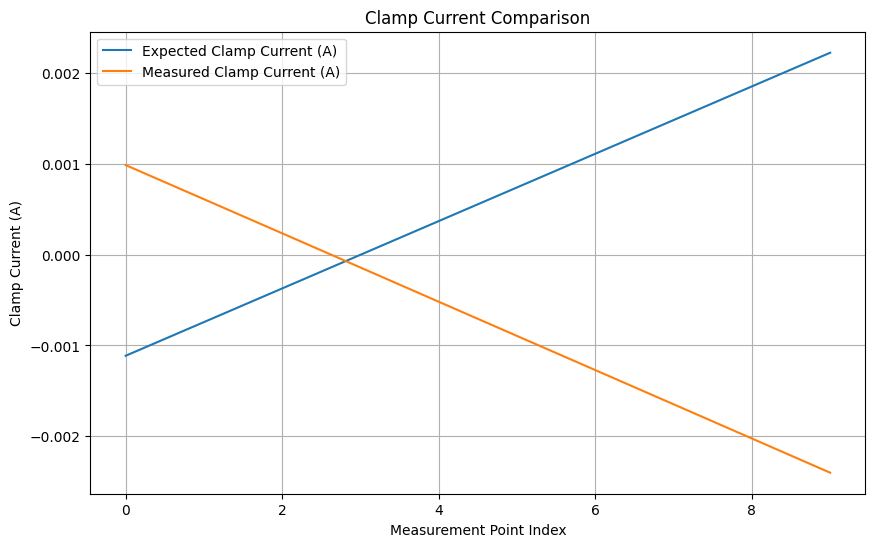

In [1]:
####    FV CL_I Trial 1 * GREAT SUCCESS* (CL_H)

from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

# Attempt to delete previous communicator instance if it exists
try:
    del(p.c)
except:
    pass

# Initialize the Keithley2600 device
k = Keithley2600('GPIB0::17::INSTR', visa_library='')

# Reset the SMU channels
k.smua.reset()
k.smub.reset()

# Initialize the PMU controller
p = pmu_ctrl.pmu()

# Disable all PMU channels initially
p.channels[0].change_pmu_reg({
    "CH EN" : 0 # disable the channel
})

# Configure the display settings for SMUA on the Keithley2600
k.display.screen = k.display.smua
k.display.smua.measure.func = k.display.MEASURE_DCAMPS

# Configure measurement settings for SMUA
k.smua.measure.nplc = 1
k.smua.measure.autorangei = k.smua.AUTORANGE_ON
k.smua.measure.autorangev = k.smua.AUTORANGE_ON

# Set source limits and enable voltage output for SMUA
k.smua.source.limiti = ((2e-3)*2)
k.smua.source.limitv = 20
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.output = k.smua.OUTPUT_ON

# Configure the system control settings for the PMU
p.change_sys_ctrl({
    "DUTGND/CH": 1,
    "INT10K": 1,
    "GAIN": 2,
    "TMP ENABLE": 1,
    "TMP": 3  # Thermal shutdown at 100°C
})

# Enable and configure the first PMU channel
p.channels[0].change_pmu_reg({
    "CH EN": 1,  # Enable the channel
    "FORCE": 0,  # Force voltage clamp current
    "SS0": 1,
    "SF0": 1,
    "FIN": 1,
    "C": 3,
    "CL": 1
})

# Define parameters for the measurement
overlap = 0.5
measure_delay = 0.1
VREF = 4.95
rsens = 500
MI_GAIN = 10
num = 10
measure_points = np.linspace(round(0x8000-(0x8000*overlap)), 0xFFFF, num)
voltage = 5
val = voltage
offset_dac = 0xA492
DAC_CODE = round(((val * (2**16) / VREF) + (3.5*offset_dac)) / 4.5)

# Write the DAC code for 5V output at "FIN_U"
p.channels[0].write_dac(
    data=DAC_CODE,
    dac_reg="FIN_U",
    reg="X1"
)

# Write CLL_I as 0000
p.channels[0].write_dac(
    data=0x0000,
    dac_reg="CLL_I",
    reg="X1"
)

# Initialize arrays to store the expected and measured clamp values
clamp_exp_array = []
clamp_meas_array = []

# Clamp from 0x0000 to 0xFFFF for an input voltage of 5V ("FIN_U")
for d in measure_points:
    p.channels[0].write_dac(
        data=round(d),
        dac_reg="CLH_I",
        reg="X1"
    )
    
    val = d
    clamp_exp = (4.5 * VREF * (val - (2**15))) / ((2**16) * rsens * MI_GAIN)
    print("expected", clamp_exp)
    sleep(measure_delay)
    clamp_meas =  k.smua.measure.i()
    
    print("measured", clamp_meas)
    
    # Append the expected and measured values to the arrays
    clamp_exp_array.append(clamp_exp)
    clamp_meas_array.append(clamp_meas)
    sleep(measure_delay)

# Turn off the SMUA output
k.smua.source.output = k.smua.OUTPUT_OFF

# Disable PMU channel
p.channels[0].change_pmu_reg({
    "CH EN" : 0 # disable the channel
})

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Expected Clamp Current (A)': clamp_exp_array,
    'Measured Clamp Current (A)': clamp_meas_array
})

# Display the DataFrame
print(results_df)

# Plot the results using pandas
results_df.plot(figsize=(10, 6), title='Clamp Current Comparison', grid=True)
plt.xlabel('Measurement Point Index')
plt.ylabel('Clamp Current (A)')
plt.show()


In [2]:
offset_dac = 0xA492
v_ref = 4.95
voltage = 5
DAC_CODE = round( ((voltage*2**16)/v_ref)+((3.5*offset_dac)/4.5))
measure_delay = 0.1
print(DAC_CODE)

98966


In [5]:
## TRIAL 2

from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

# Attempt to delete previous communicator instance if it exists
try:
    del(p.c)
except:
    pass

# Initialize the Keithley2600 device
k = Keithley2600('GPIB0::26::INSTR', visa_library='')

# Reset the SMU channels
k.smua.reset()
k.smub.reset()

# Initialize the PMU controller
p = pmu_ctrl.pmu()

p.channels[0].change_pmu_reg({
    "CH EN" : 0
})

k.display.screen = k.display.SMUA
k.display.smua.measure.func = k.display.MEASURE_DCAMPS

k.smua.measure.nplc = 1
k.smua.measure.autorangei = k.smua.AUTORANGE_ON
k.smua.measure.autorangev = k.smua.AUTORANGE_ON

k.smua.source.limiti = ((2e-3)*2)
k.smua.source.limitv = 20
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})

p.channels[0].change_pmu_reg({
    "CH EN": 1,     #Channel enable
    "FORCE": 0,     #FV
    "SS0"  : 1,
    "SF0"  : 1,
    "FIN"  : 1,
    "C"    : 3,
    "CL"   : 1
})

overlap = 0.5
num = 10

measure_points = np.linspace(round(0x8000-(0x8000*overlap)), 0xFFFF, num)
val = 5
offset_dac = 0xA492
VREF = 4.95
DAC_C = round(((val * (2**16) / VREF) + (3.5*offset_dac)) / 4.5)

measure_delay = 0.1

## Writing the DAC code for 5 v to FIN U

p.channels[0].write_dac(
    data = 0xDAC_C,
    dac_reg = "FIN_U",
    reg = "X1"
    )

## Writing Clamp Low to zero

p.channels[0].write_dac(
    data = 0x0000,
    dac_reg = "CLL_I",
    reg = "X1"
)

dac_regi = "CLH_I"

clamp_measured_values = []

for d in measure_points :
    p.channels[0].write_dac(
        data = round(d),
        dac_reg = dac_regi,
        reg = "X1"
    )
    sleep(measure_delay)
    clamp_measured = k.smua.measure.i()
    clamp_measured_values.append(clamp_measured)
    val = d
    rsens = 500
    MI_GAIN =10
    clamp_expected = (4.5 * VREF * (val-(2**15))) / ((2**16)*rsens*MI_GAIN)

    print("Expected Clamping :",clamp_expected)
    print("Measured Clamping :",clamp_measured)
    

p.channels[0].change_pmu_reg({
    "CH EN" :0
})

k.smua.source.output = k.smua.OUTPUT_OFF
print(clamp_measured_values)
 



Expected Clamping : -0.0011137500000000002
Measured Clamping : -1.46627e-12
Expected Clamping : -0.0007425075531005859
Measured Clamping : 2.76566e-12
Expected Clamping : -0.00037126510620117184
Measured Clamping : 1.83582e-12
Expected Clamping : -2.2659301757730066e-08
Measured Clamping : -5.72205e-12
Expected Clamping : 0.0003712197875976564
Measured Clamping : -2.37226e-12
Expected Clamping : 0.0007424622344970702
Measured Clamping : -3.54052e-12
Expected Clamping : 0.0011137046813964847
Measured Clamping : -2.16961e-12
Expected Clamping : 0.001484947128295899
Measured Clamping : -7.86781e-13
Expected Clamping : 0.001856189575195313
Measured Clamping : 7.51019e-13
Expected Clamping : 0.0022274320220947268
Measured Clamping : -2.30074e-12
[-1.46627e-12, 2.76566e-12, 1.83582e-12, -5.72205e-12, -2.37226e-12, -3.54052e-12, -2.16961e-12, -7.86781e-13, 7.51019e-13, -2.30074e-12]


In [6]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 2.76566e-12,  7.15256e-14,  2.46763e-12, -3.82662e-12,
        -3.48091e-12, -3.57628e-13, -6.67572e-13, -1.89543e-12,
        -2.92063e-12, -1.65701e-12]))

In [4]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 3.60012e-12,  1.59740e-12,  6.31809e-13, -3.46899e-12,
        -6.31809e-13, -2.34842e-12, -2.89679e-12, -7.98702e-13,
        -2.69413e-12, -1.41859e-12]))

In [13]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 5.51939e-12,  1.65701e-12,  1.46627e-12, -3.00407e-12,
        -3.29018e-12, -2.69413e-12, -2.03848e-12, -1.06096e-12,
        -1.37091e-12,  6.07967e-13]))

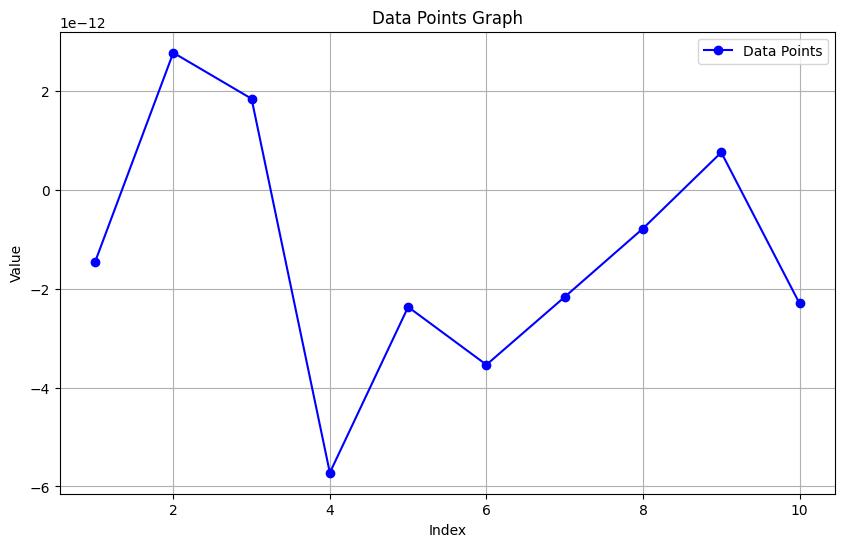

In [7]:
import matplotlib.pyplot as plt

# Data points provided
data_points = [
  -1.46627e-12, 2.76566e-12, 1.83582e-12, -5.72205e-12, -2.37226e-12, -3.54052e-12, -2.16961e-12, -7.86781e-13, 7.51019e-13, -2.30074e-12
]

# Create a sequence of indices for the x-axis
x_values = range(1, len(data_points) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, data_points, marker='o', linestyle='-', color='b', label='Data Points')

# Adding titles and labels
plt.title('Data Points Graph')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


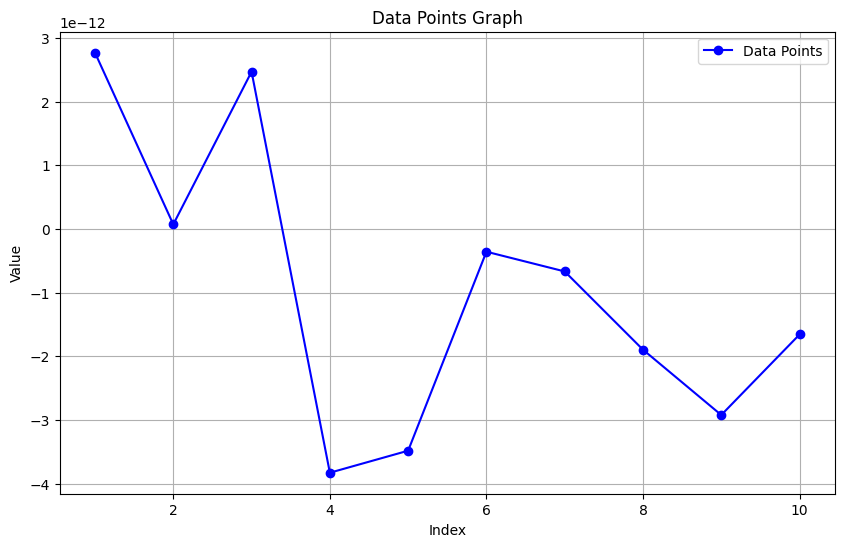

In [8]:
import matplotlib.pyplot as plt

# Data points provided
data_points = [
   2.76566e-12,  7.15256e-14,  2.46763e-12, -3.82662e-12,
        -3.48091e-12, -3.57628e-13, -6.67572e-13, -1.89543e-12,
        -2.92063e-12, -1.65701e-12
]

# Create a sequence of indices for the x-axis
x_values = range(1, len(data_points) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, data_points, marker='o', linestyle='-', color='b', label='Data Points')

# Adding titles and labels
plt.title('Data Points Graph')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


In [33]:

## SMU and PMU Setup

#p.write_all_PMU_REGS(0x1E060)
#p.write_all_PMU_REGS(0x21fc60)


# k.display.screen            = k.display.SMUA
# k.display.smua.measure.func = k.display.MEASURE_DCVOLTS
    
# k.smua.measure.rangev       = 20
# k.smua.measure.autorangei   = k.smua.AUTORANGE_ON
# #k.smua.measure.autorangev   = k.smua.AUTORANGE_ON
# k.smua.measure.nplc         = 1    
# k.smua.source.func          = k.smua.OUTPUT_DCAMPS
# k.smua.source.leveli        = 0
# k.smua.source.limiti        = 1e-3
# k.smua.source.limitv        = 20
# k.smua.source.output        = k.smua.OUTPUT_ON

# p.change_sys_ctrl({
#         "DUTGND/CH" : 1,
#         "INT10K"    : 1,
#         "GAIN"      : 2,
#         "TMP ENABLE": 1,
#         "TMP"       : 3 # Thermal shutdown at 100°C
#     })
#p_reg = 0x21fc60
#Change PMU register settings for the current channel
p.channels[ch].change_pmu_reg({
        "CH EN": 1,      # Channel enable
        "FORCE": 0,      # FV
        "C": 3,
        "MEAS": 3,       # VSens
        "SS0": 1,
        "SF0": 1,        # 1,1
        "FIN": 1
    })


In [34]:
p.decode_pmu_reg()

,CH EN,FORCE,C,MEAS,FIN,SF0,SS0,CL,CPOLH,COMPARE V/I,LTMPALMn,TMPALMn
0,1,0,3,3,1,1,1,0,0,0,1,1
1,1,0,3,3,1,1,1,0,0,0,1,1
2,1,0,3,3,1,1,1,0,0,0,1,1
3,1,0,3,3,1,1,1,0,0,0,1,1


0
Writing data 0.0: 0.0
Writing data 3449.2105263157896: 3449.2105263157896
Writing data 6898.421052631579: 6898.421052631579
Writing data 10347.631578947368: 10347.631578947368
Writing data 13796.842105263158: 13796.842105263158
Writing data 17246.052631578947: 17246.052631578947
Writing data 20695.263157894737: 20695.263157894737
Writing data 24144.473684210527: 24144.473684210527
Writing data 27593.684210526317: 27593.684210526317
Writing data 31042.894736842107: 31042.894736842107
Writing data 34492.10526315789: 34492.10526315789
Writing data 37941.31578947369: 37941.31578947369
Writing data 41390.52631578947: 41390.52631578947
Writing data 44839.73684210527: 44839.73684210527
Writing data 48288.94736842105: 48288.94736842105
Writing data 51738.15789473685: 51738.15789473685
Writing data 55187.36842105263: 55187.36842105263
Writing data 58636.57894736842: 58636.57894736842
Writing data 62085.78947368421: 62085.78947368421
Writing data 65535.0: 65535.0

Data stored in DataFrame:
   

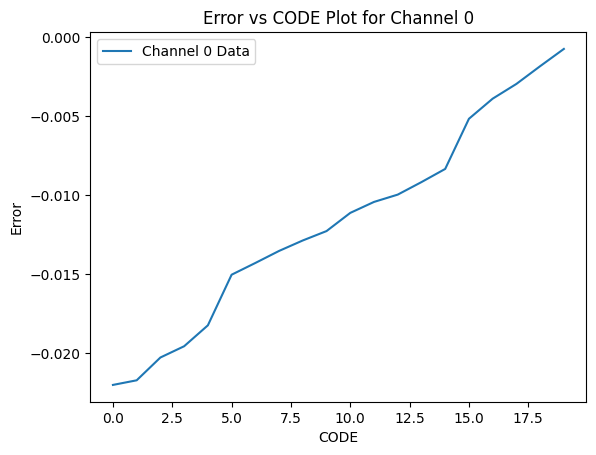


New DataFrame containing values of all four previous DataFrames:
            CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0       0.000000       -11.249924   -11.227900 -0.022024
1    3449.210526       -10.065731   -10.044000 -0.021731
2    6898.421053        -8.881539    -8.861250 -0.020289
3   10347.631579        -7.697346    -7.677770 -0.019576
4   13796.842105        -6.513154    -6.494900 -0.018254
5   17246.052632        -5.328961    -5.313910 -0.015051
6   20695.263158        -4.144769    -4.130460 -0.014309
7   24144.473684        -2.960577    -2.947030 -0.013547
8   27593.684211        -1.776384    -1.763500 -0.012884
9   31042.894737        -0.592192    -0.579901 -0.012291
10  34492.105263         0.592001     0.603141 -0.011140
11  37941.315789         1.776193     1.786640 -0.010447
12  41390.526316         2.960386     2.970370 -0.009984
13  44839.736842         4.144578     4.153770 -0.009192
14  48288.947368         5.328771     5.337130 -0.008359
15  51738.157895      

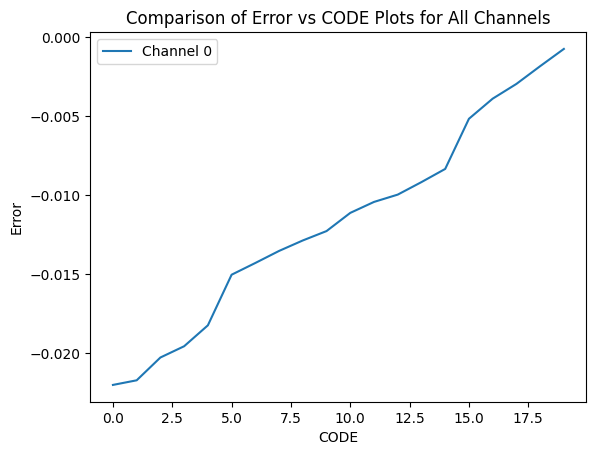

In [1]:

# FV Full program

from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt




try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')
#k.smua.source.output = k.smua.OUTPUT_OFF

k.smua.reset()
k.smub.reset()
measure_delay = 0.1
MEAS_NPLC = 1

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
p.decode_pmu_reg()

## SMU and PMU Setup

p.write_all_PMU_REGS(0x1E060)

k.display.screen            = k.display.SMUA
k.display.smua.measure.func = k.display.MEASURE_DCVOLTS

k.smua.measure.autorangev   = k.smua.AUTORANGE_ON
k.smua.measure.nplc = MEAS_NPLC

k.smua.source.func          = k.smua.OUTPUT_DCAMPS
k.smua.source.leveli        = 0
k.smua.source.limiti        = 1e-3
k.smua.source.limitv        = 20
k.smua.source.output        = k.smua.OUTPUT_ON

    




p.change_sys_ctrl({
        "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 2,
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C
    })

p.decode_pmu_reg()

for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0  #1,1

    })



#import pandas as pd


# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(1):
    print(ch)
   
  #  p.write_all_PMU_REGS(0x21fc60)
    
    #p.channels[ch].change_pmu_reg = 0x21fc60
    
    #Change PMU register settings for the current channel
    p_ch = p.channels[ch]
    p_ch.pmu_reg = 0x21fc60
        
    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF
    k.smua.source.output = k.smua.OUTPUT_ON

    data_list = []
    measure_points = np.linspace(0, 0xFFFF,20)

    

    # Calculate the step size to generate 20 equidistant data points
   # step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for d in  measure_points:
        # Calculate the data value for the current index
       # data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {d }: {(d)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=round(d),
            dac_reg="FIN_U",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(measure_delay)

        iv_data = k.smua.measure.v()
        V_REF = 5
       

        # Print the measurement outputs
        #print(f"Measurement outputs : {iv_data}")

        # Calculate expected output and error
      
        VOUT = ((4.5 * d) - (3.5 * 42130)) * (V_REF / (2**16))
        error = VOUT - iv_data
        #print(f"Expected Output : {VOUT}")

        # Append data to the list
        data_list.append({"CODE": (d), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')

    # Add legend and labels
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()

    # Show the plot
    plt.show()
    k.smua.source.output = k.smua.OUTPUT_OFF
    p.channels[ch].change_pmu_reg({
        "CH EN": 0
        })



    

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    
    sleep(measure_delay)
    

# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

# Add legend and labels
plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])



 # Enable beeper and play chord
k.beeper.enable = k.beeper.ON
k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.2)
k.beeper.enable = k.beeper.OFF



In [5]:

 # Enable beeper and play chord
k.beeper.enable = k.beeper.ON
k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.2)
k.beeper.enable = k.beeper.OFF
k.smua.source.output = k.smua.OUTPUT_OFF
p.decode_pmu_reg()

,CH EN,FORCE,C,MEAS,FIN,SF0,SS0,CL,CPOLH,COMPARE V/I,LTMPALMn,TMPALMn
0,0,0,3,3,1,0,0,0,0,0,1,1
1,0,0,3,3,1,0,0,0,0,0,1,1
2,0,0,3,3,1,0,0,0,0,0,1,1
3,0,0,3,3,1,0,0,0,0,0,1,1


In [37]:
for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0  #1,1

    })

In [7]:
p.decode_sys_ctrl()


{'CL': 0,
 'CPOLH': 0,
 'CPBIASEN': 0,
 'DUTGND/CH': 1,
 'GUARD ALM': 0,
 'CLAMP ALM': 0,
 'INT10K': 1,
 'GUARD EN': 1,
 'GAIN': 2,
 'TMP ENABLE': 1,
 'TMP': 3,
 'LATCHED': 0}

0
Writing data 0.0: 0.0
Measurement outputs : -11.2265
Expected Output : -11.249923706054688
Writing data 3449.2105263157896: 3449.2105263157896
Measurement outputs : -10.0433
Expected Output : -10.065731249357524
Writing data 6898.421052631579: 6898.421052631579
Measurement outputs : -8.86047
Expected Output : -8.881538792660361
Writing data 10347.631578947368: 10347.631578947368
Measurement outputs : -7.67718
Expected Output : -7.697346335963199
Writing data 13796.842105263158: 13796.842105263158
Measurement outputs : -6.4944
Expected Output : -6.513153879266036
Writing data 17246.052631578947: 17246.052631578947
Measurement outputs : -5.31146
Expected Output : -5.328961422568874
Writing data 20695.263157894737: 20695.263157894737
Measurement outputs : -4.12857
Expected Output : -4.144768965871711
Writing data 24144.473684210527: 24144.473684210527
Measurement outputs : -2.94564
Expected Output : -2.9605765091745475
Writing data 27593.684210526317: 27593.684210526317
Measurement outp

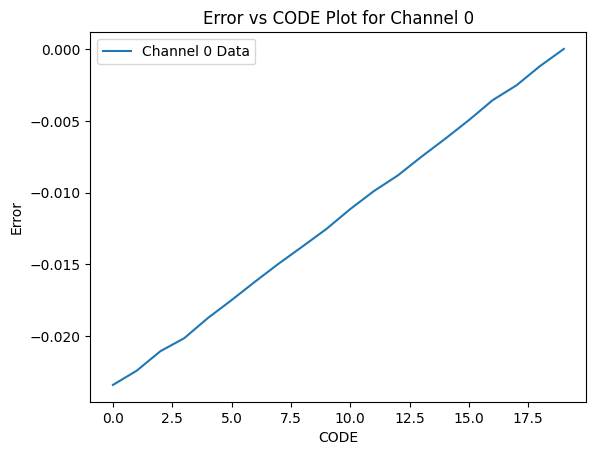

1
Writing data 0.0: 0.0
Measurement outputs : -11.2418
Expected Output : -11.249923706054688
Writing data 3449.2105263157896: 3449.2105263157896
Measurement outputs : -10.0581
Expected Output : -10.065731249357524
Writing data 6898.421052631579: 6898.421052631579
Measurement outputs : -8.87481
Expected Output : -8.881538792660361
Writing data 10347.631578947368: 10347.631578947368
Measurement outputs : -7.69099
Expected Output : -7.697346335963199
Writing data 13796.842105263158: 13796.842105263158
Measurement outputs : -6.50772
Expected Output : -6.513153879266036
Writing data 17246.052631578947: 17246.052631578947
Measurement outputs : -5.32436
Expected Output : -5.328961422568874
Writing data 20695.263157894737: 20695.263157894737
Measurement outputs : -4.14096
Expected Output : -4.144768965871711
Writing data 24144.473684210527: 24144.473684210527
Measurement outputs : -2.95759
Expected Output : -2.9605765091745475
Writing data 27593.684210526317: 27593.684210526317
Measurement out

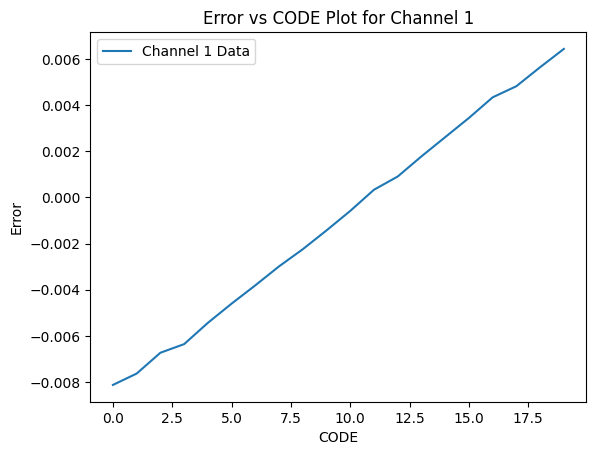

2
Writing data 0.0: 0.0
Measurement outputs : -11.2184
Expected Output : -11.249923706054688
Writing data 3449.2105263157896: 3449.2105263157896
Measurement outputs : -10.0353
Expected Output : -10.065731249357524
Writing data 6898.421052631579: 6898.421052631579
Measurement outputs : -8.8526
Expected Output : -8.881538792660361
Writing data 10347.631578947368: 10347.631578947368
Measurement outputs : -7.66935
Expected Output : -7.697346335963199
Writing data 13796.842105263158: 13796.842105263158
Measurement outputs : -6.48671
Expected Output : -6.513153879266036
Writing data 17246.052631578947: 17246.052631578947
Measurement outputs : -5.30384
Expected Output : -5.328961422568874
Writing data 20695.263157894737: 20695.263157894737
Measurement outputs : -4.12105
Expected Output : -4.144768965871711
Writing data 24144.473684210527: 24144.473684210527
Measurement outputs : -2.93819
Expected Output : -2.9605765091745475
Writing data 27593.684210526317: 27593.684210526317
Measurement outp

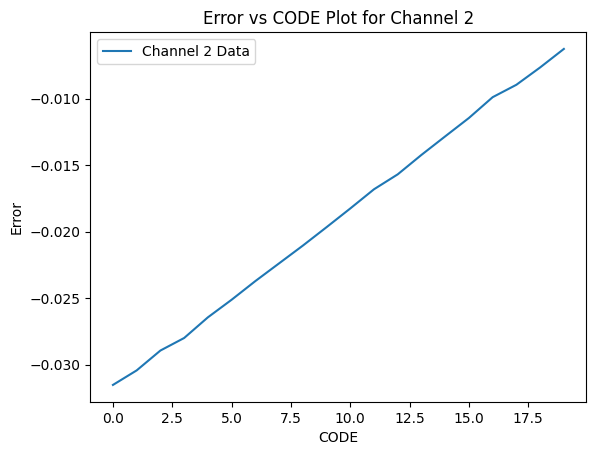

3
Writing data 0.0: 0.0
Measurement outputs : -11.2296
Expected Output : -11.249923706054688
Writing data 3449.2105263157896: 3449.2105263157896
Measurement outputs : -10.0464
Expected Output : -10.065731249357524
Writing data 6898.421052631579: 6898.421052631579
Measurement outputs : -8.86347
Expected Output : -8.881538792660361
Writing data 10347.631578947368: 10347.631578947368
Measurement outputs : -7.68011
Expected Output : -7.697346335963199
Writing data 13796.842105263158: 13796.842105263158
Measurement outputs : -6.49717
Expected Output : -6.513153879266036
Writing data 17246.052631578947: 17246.052631578947
Measurement outputs : -5.31419
Expected Output : -5.328961422568874
Writing data 20695.263157894737: 20695.263157894737
Measurement outputs : -4.13121
Expected Output : -4.144768965871711
Writing data 24144.473684210527: 24144.473684210527
Measurement outputs : -2.94813
Expected Output : -2.9605765091745475
Writing data 27593.684210526317: 27593.684210526317
Measurement out

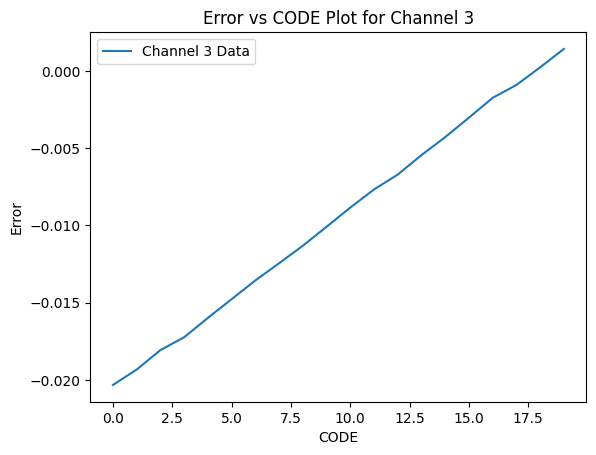


New DataFrame containing values of all four previous DataFrames:
            CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0       0.000000       -11.249924    -11.22650 -0.023424
1    3449.210526       -10.065731    -10.04330 -0.022431
2    6898.421053        -8.881539     -8.86047 -0.021069
3   10347.631579        -7.697346     -7.67718 -0.020166
4   13796.842105        -6.513154     -6.49440 -0.018754
..           ...              ...          ...       ...
15  51738.157895         6.512963      6.51598 -0.003017
16  55187.368421         7.697156      7.69889 -0.001734
17  58636.578947         8.881348      8.88225 -0.000902
18  62085.789474        10.065541     10.06530  0.000241
19  65535.000000        11.249733     11.24830  0.001433

[80 rows x 4 columns]


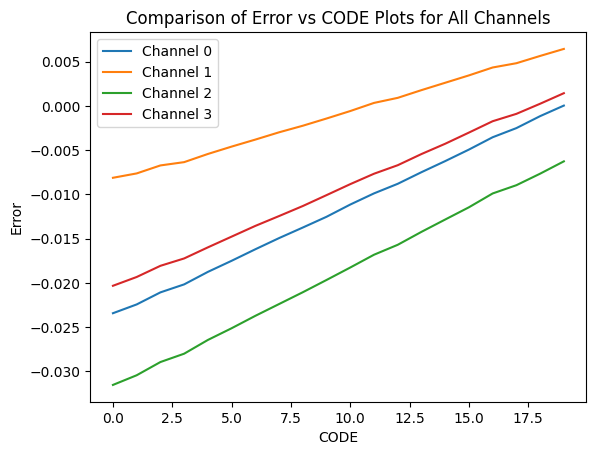

In [15]:

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)

    #p.channels[ch].change_pmu_reg = 0x21fc60
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,      # Channel enable
        "FORCE": 0,      # FV
        "C": 3,
        "MEAS": 3,       # VSens
        "SS0": 1,
        "SF0": 1,        # 1,1
        "FIN": 1
    })
        
    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF
    k.smua.source.output = k.smua.OUTPUT_ON

    data_list = []
    measure_points = np.linspace(0, 0xFFFF, 20)
    

    # Calculate the step size to generate 20 equidistant data points
   # step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for d in  measure_points:
        # Calculate the data value for the current index
       # data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {d }: {(d)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=round(d),
            dac_reg="FIN_U",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(2)

        iv_data = k.smua.measure.v()

        # Print the measurement outputs
        print(f"Measurement outputs : {iv_data}")

        # Calculate expected output and error
        VOUT = 4.5 * 5 * (d/ 2**16) - (3.5 * 5 * (42130 / 2**16)) + 0
        error = VOUT - iv_data
        print(f"Expected Output : {VOUT}")

        # Append data to the list
        data_list.append({"CODE": (d), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')

    # Add legend and labels
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()

    # Show the plot
    plt.show()
    k.smua.source.output = k.smua.OUTPUT_OFF
    p.channels[ch].change_pmu_reg({
        "CH EN": 0
        })



    

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    
    sleep(2)
    

# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

# Add legend and labels
plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])

# Show the plot

0
Writing data 1: 0x0
Measurement outputs : -11.2253
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.0431
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -8.86001
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.67694
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.49396
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.31126
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.12835
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -2.94552
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -1.76293
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.580192
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.602536
Expected Output : 0.5912780761

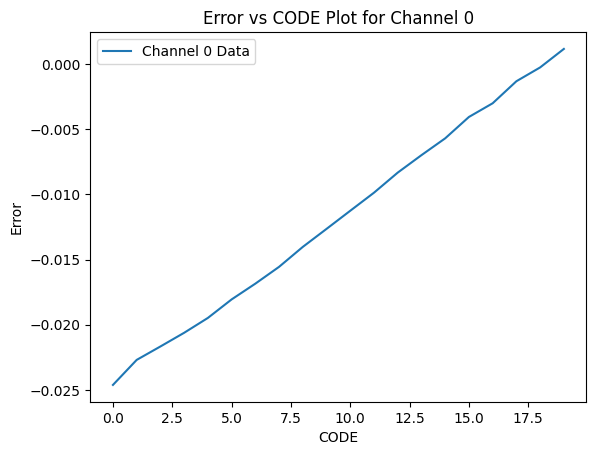

1
Writing data 1: 0x0
Measurement outputs : -11.24
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.0561
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -8.87299
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.68985
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.50717
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.32399
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.14055
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -2.95734
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -1.77441
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.59113
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.592055
Expected Output : 0.5912780761718

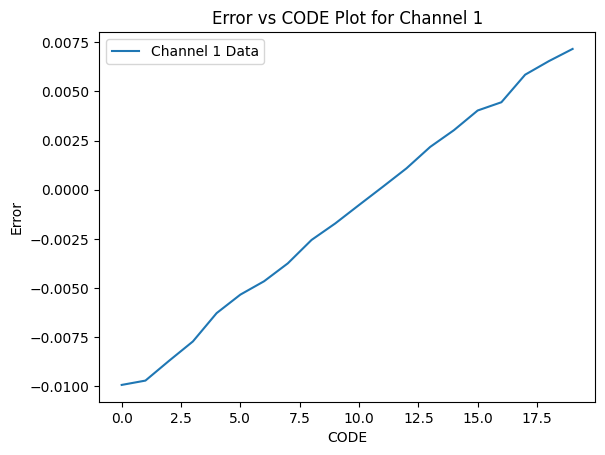

2
Writing data 1: 0x0
Measurement outputs : -11.2176
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.0343
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -8.85151
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.66859
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.48605
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.3031
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.12071
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -2.93802
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -1.75565
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.572991
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.609655
Expected Output : 0.59127807617

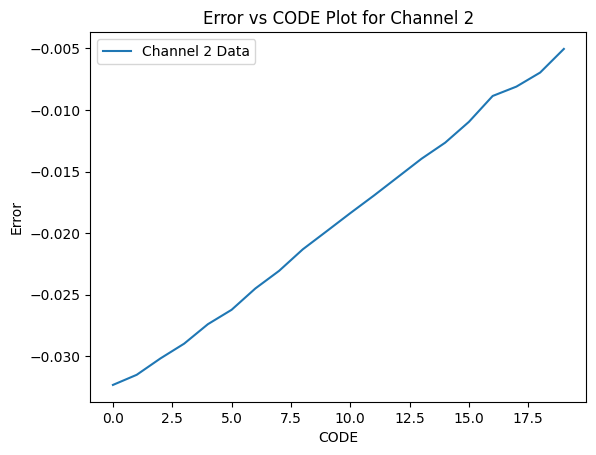

3
Writing data 1: 0x0
Measurement outputs : -11.2279
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.0445
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -8.86234
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.67915
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.49668
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.31374
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.13084
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -2.94794
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -1.76534
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.582452
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.600295
Expected Output : 0.5912780761

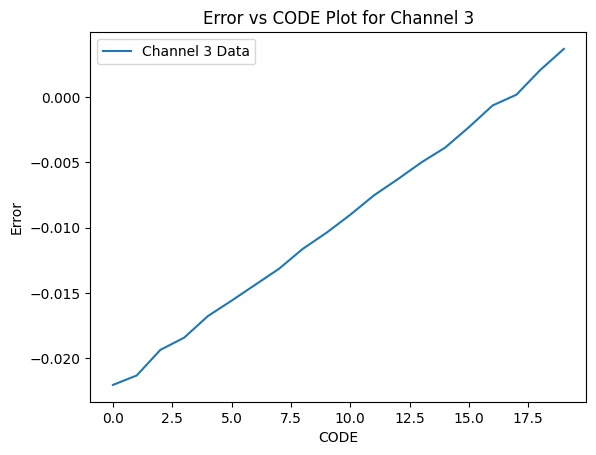


New DataFrame containing values of all four previous DataFrames:
      CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0x0       -11.249924    -11.22530 -0.024624
1    0xd79       -10.065804    -10.04310 -0.022704
2   0x1af2        -8.881683     -8.86001 -0.021673
3   0x286b        -7.697563     -7.67694 -0.020623
4   0x35e4        -6.513443     -6.49396 -0.019483
..     ...              ...          ...       ...
15  0xca17         6.511879      6.51420 -0.002321
16  0xd790         7.695999      7.69666 -0.000661
17  0xe509         8.880119      8.87996  0.000159
18  0xf282        10.064240     10.06220  0.002040
19  0xfffb        11.248360     11.24470  0.003660

[80 rows x 4 columns]


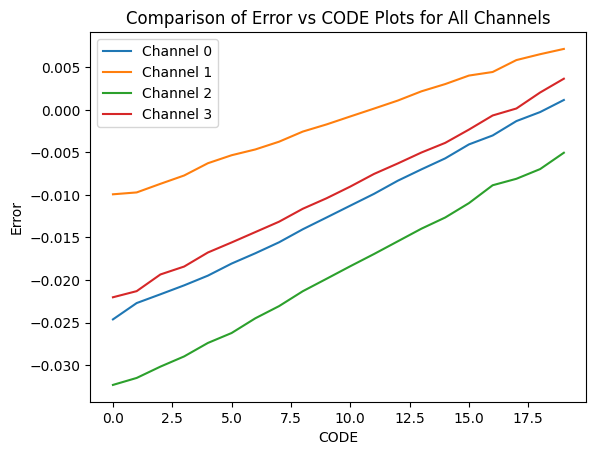

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)

    #p.channels[ch].change_pmu_reg = 0x21fc60
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,      # Channel enable
        "FORCE": 0,      # FV
        "C": 3,
        "MEAS": 3,       # VSens
        "SS0": 1,
        "SF0": 1,        # 1,1
        "FIN": 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for i in range(20):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=round(data),
            dac_reg="FIN_U",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(2)

        iv_data = k.smua.measure.v()

        # Print the measurement outputs
        print(f"Measurement outputs : {iv_data}")

        # Calculate expected output and error
        VOUT = 4.5 * 5 * (round(int(data))/ 2**16) - (3.5 * 5 * (42130 / 2**16)) + 0
        error = VOUT - iv_data
        print(f"Expected Output : {VOUT}")

        # Append data to the list
        data_list.append({"CODE": hex(data), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')

    # Add legend and labels
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()

    # Show the plot
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    
    sleep(2)
    

# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

# Add legend and labels
plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])

# Show the plot
plt.show()


In [15]:
p.read_dac_regs(reg="X1")

,Offset,FIN_I_5u,FIN_I_20u,FIN_I_200u,FIN_I_2m,FIN_I_ext,FIN_U,CLL_I,CLL_U,CLH_I,CLH_U
0,42130,32768,32768,32768,32768,32768,65531,0,0,65535,65535
1,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535
2,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535
3,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535


In [12]:
p.read_dac_regs(reg="M")

,FIN_I_5u,FIN_I_20u,FIN_I_200u,FIN_I_2m,FIN_I_ext,FIN_U,CLL_I,CLL_U,CLH_I,CLH_U
0,65535,65535,65535,65535,65535,65535,65535,65535,65535,65535
1,65535,65535,65535,65535,65535,65535,65535,65535,65535,65535
2,65535,65535,65535,65535,65535,65535,65535,65535,65535,65535
3,65535,65535,65535,65535,65535,65535,65535,65535,65535,65535


In [8]:
p.read_dac_regs(reg="X1")

,Offset,FIN_I_5u,FIN_I_20u,FIN_I_200u,FIN_I_2m,FIN_I_ext,FIN_U,CLL_I,CLL_U,CLH_I,CLH_U
0,42130,32768,32768,32768,32768,32768,65531,0,0,65535,65535
1,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535
2,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535
3,42130,32768,32768,32768,32768,32768,32768,0,0,65535,65535


Writing data: 0x0
Measurement outputs : 0.000214577
Expected Output : -11.249923706054688
Writing data: 0xffff
Measurement outputs : 0.000195503
Expected Output : 11.249732971191406
Writing data: 0x0
Measurement outputs : 0.000138283
Expected Output : -11.249923706054688
Writing data: 0xffff
Measurement outputs : 0.000190735
Expected Output : 11.249732971191406
Writing data: 0x0
Measurement outputs : 0.000181198
Expected Output : -11.249923706054688
Writing data: 0xffff
Measurement outputs : 0.000171661
Expected Output : 11.249732971191406
Writing data: 0x0
Measurement outputs : 0.000190735
Expected Output : -11.249923706054688
Writing data: 0xffff
Measurement outputs : 0.000171661
Expected Output : 11.249732971191406
Writing data: 0x0
Measurement outputs : 0.00014782
Expected Output : -11.249923706054688
Writing data: 0xffff
Measurement outputs : 0.000181198
Expected Output : 11.249732971191406
Writing data: 0x0
Measurement outputs : 0.000195503
Expected Output : -11.249923706054688
W

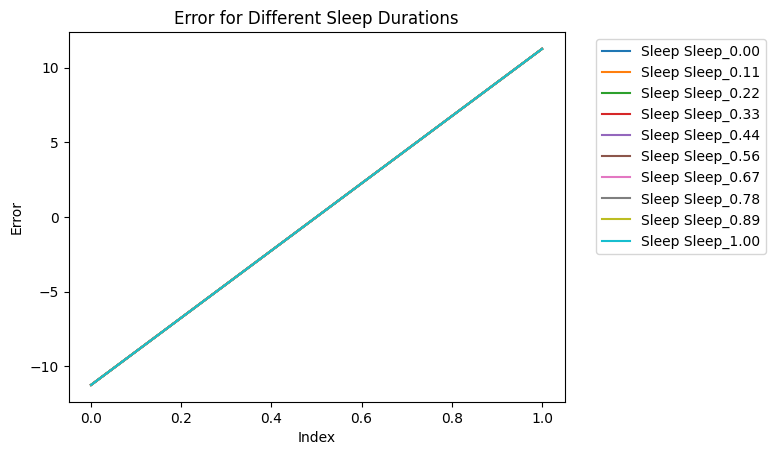

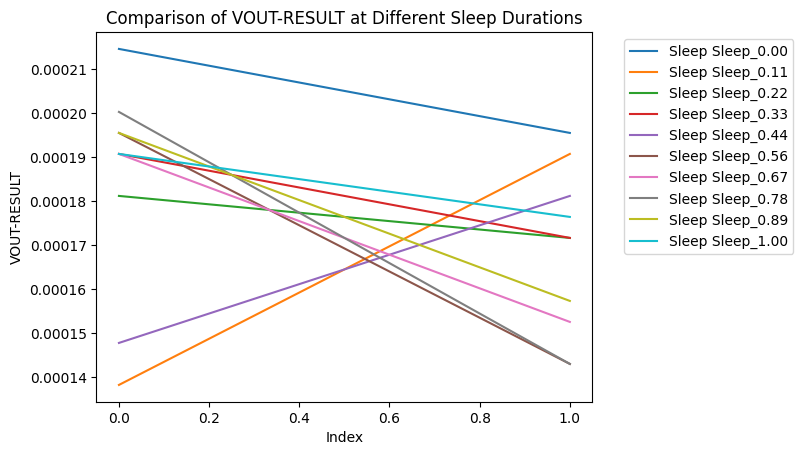

In [8]:
import numpy as np

# Generate 10 equidistant sleep durations between 0 and 1
sleep_durations = np.linspace(0, 1, 10)

# Initialize a dictionary to store dataframes for each sleep duration
dataframes = {}

# Outer loop for different sleep durations
for sleep_duration in sleep_durations:
    data_list = []
    
    # Write 0x0000 and 0xFFFF
    for data in [0x0000, 0xFFFF]:

        # Print the data being written to the DAC register
        print(f"Writing data: {hex(data)}")

        # Write the data to the DAC register
        p.channels[0].write_dac(
            data=data,
            dac_reg="FIN_U",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(sleep_duration)

        iv_data = k.smua.measure.v()

        # Print the measurement outputs
        print(f"Measurement outputs : {iv_data}")

        VOUT = 4.5 * 5 * (int(data)/2**16) - (3.5 * 5 * (42130/2**16)) + 0
        error = VOUT - iv_data
        print(f"Expected Output : {VOUT}")
        data_list.append({"CODE": hex(data), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

    # Create a dataframe for the current sleep duration
    dataframes[f"Sleep_{sleep_duration:.2f}"] = pd.DataFrame(data_list)

# Display the dataframes
for key, df in dataframes.items():
    print(f"\nData stored in DataFrame for {key}:")
    print(df)

# Plot Error for all sleeps
for key, df in dataframes.items():
    plt.plot(df.index, df["Error"], label=f"Sleep {key}")

plt.xlabel("Index")
plt.ylabel("Error")
plt.title("Error for Different Sleep Durations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot comparison of all plots at 10 sleeps
for key, df in dataframes.items():
    plt.plot(df.index, df["VOUT-RESULT"], label=f"Sleep {key}")

plt.xlabel("Index")
plt.ylabel("VOUT-RESULT")
plt.title("Comparison of VOUT-RESULT at Different Sleep Durations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Writing data 1: 0x0
Measurement outputs : -7.38028
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.3222
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -9.14401
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.97401
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.78508
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.60464
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.4213
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -3.23383
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -2.04447
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.87429
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.31322
Expected Output : 0.591278076171875

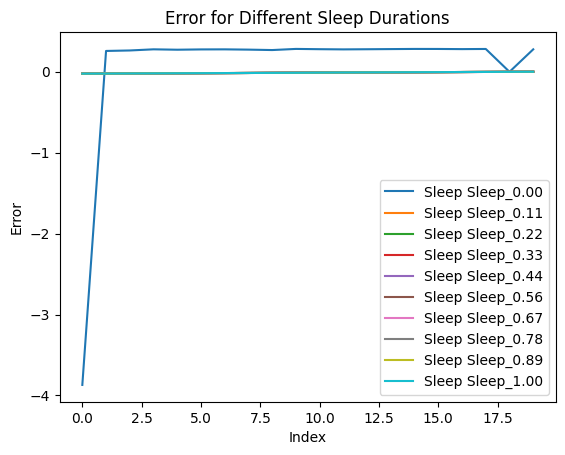

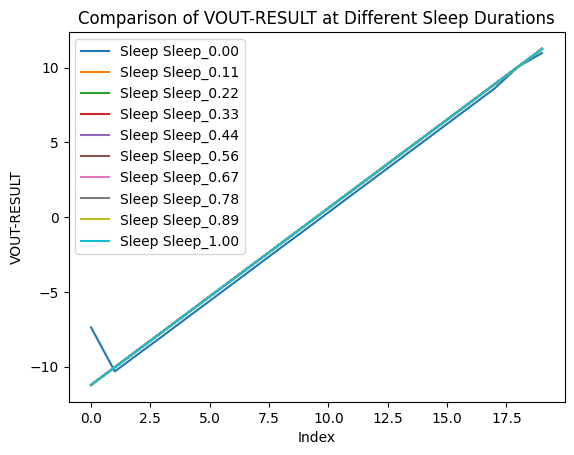

In [109]:
# import numpy as np

# # Generate 10 equidistant sleep durations between 0 and 1
# sleep_durations = np.linspace(0, 1, 10)

# # Initialize a dictionary to store dataframes for each sleep duration
# dataframes = {}

# # Outer loop for different sleep durations
# for sleep_duration in sleep_durations:
#     data_list = []
    
#     # Loop to generate and write equidistant data points
#     for i in range(20):
#         # Calculate the data value for the current index
#         data = i * step_size

#         # Print the data being written to the DAC register
#         print(f"Writing data {i + 1}: {hex(data)}")

#         # Write the data to the DAC register
#         p.channels[0].write_dac(
#             data=data,
#             dac_reg="FIN_U",
#             reg="X1"
#         )

#         # Perform measurement after writing to the DAC register
#         sleep(sleep_duration)

#         iv_data = k.smua.measure.v()

#         # Print the measurement outputs
#         print(f"Measurement outputs : {iv_data}")

#         VOUT = 4.5 * 5 * (int(data)/2**16) - (3.5 * 5 * (42130/2**16)) + 0
#         error = VOUT - iv_data
#         print(f"Expected Output : {VOUT}")
#         data_list.append({"CODE": hex(data), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

#     # Create a dataframe for the current sleep duration
#     dataframes[f"Sleep_{sleep_duration:.2f}"] = pd.DataFrame(data_list)

# # Display the dataframes
# for key, df in dataframes.items():
#     print(f"\nData stored in DataFrame for {key}:")
#     print(df)

# # Plot Error for all sleeps
# for key, df in dataframes.items():
#     plt.plot(df.index, df["Error"], label=f"Sleep {key}")

# plt.xlabel("Index")
# plt.ylabel("Error")
# plt.title("Error for Different Sleep Durations")
# plt.legend()
# plt.show()

# # Plot comparison of all plots at 10 sleeps
# for key, df in dataframes.items():
#     plt.plot(df.index, df["VOUT-RESULT"], label=f"Sleep {key}")

# plt.xlabel("Index")
# plt.ylabel("VOUT-RESULT")
# plt.title("Comparison of VOUT-RESULT at Different Sleep Durations")
# plt.legend()
# plt.show()


Writing data 1: 0x0
Measurement outputs : -11.2262
Expected Output : -11.249923706054688
Writing data 2: 0xd79
Measurement outputs : -10.043
Expected Output : -10.065803527832031
Writing data 3: 0x1af2
Measurement outputs : -8.86018
Expected Output : -8.881683349609375
Writing data 4: 0x286b
Measurement outputs : -7.67714
Expected Output : -7.697563171386719
Writing data 5: 0x35e4
Measurement outputs : -6.49427
Expected Output : -6.5134429931640625
Writing data 6: 0x435d
Measurement outputs : -5.31138
Expected Output : -5.329322814941406
Writing data 7: 0x50d6
Measurement outputs : -4.12844
Expected Output : -4.14520263671875
Writing data 8: 0x5e4f
Measurement outputs : -2.94545
Expected Output : -2.9610824584960938
Writing data 9: 0x6bc8
Measurement outputs : -1.76273
Expected Output : -1.7769622802734375
Writing data 10: 0x7941
Measurement outputs : -0.579839
Expected Output : -0.5928421020507812
Writing data 11: 0x86ba
Measurement outputs : 0.602388
Expected Output : 0.5912780761718

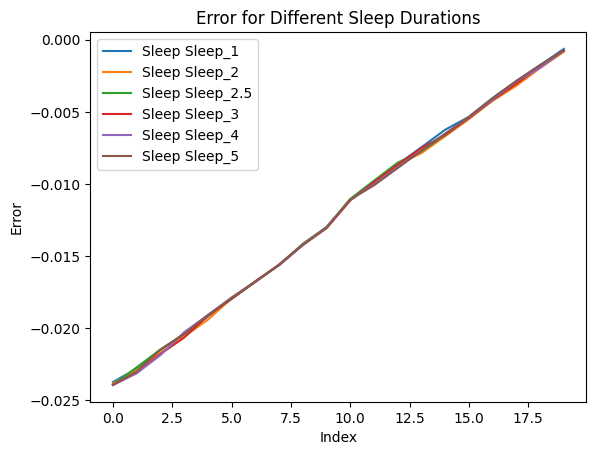

In [55]:



## Comparing the error values for different delays and plotting them

# import pandas as pd
# import matplotlib.pyplot as plt

# # Define sleep durations
# sleep_durations = [1, 2, 2.5, 3,4,5]

# # Initialize a dictionary to store dataframes for each sleep duration
# dataframes = {}

# # Outer loop for different sleep durations
# for sleep_duration in sleep_durations:
#     data_list = []
    
#     # Loop to generate and write equidistant data points
#     for i in range(20):
#         # Calculate the data value for the current index
#         data = i * step_size

#         # Print the data being written to the DAC register
#         print(f"Writing data {i + 1}: {hex(data)}")

#         # Write the data to the DAC register
#         p.channels[0].write_dac(
#             data=data,
#             dac_reg="FIN_U",
#             reg="X1"
#         )

#         # Perform measurement after writing to the DAC register
#         sleep(sleep_duration)

#         iv_data = k.smua.measure.v()

#         # Print the measurement outputs
#         print(f"Measurement outputs : {iv_data}")

#         VOUT = 4.5 * 5 * (int(data)/2**16) - (3.5 * 5 * (42130/2**16)) + 0
#         error = VOUT - iv_data
#         print(f"Expected Output : {VOUT}")
#         data_list.append({"CODE": hex(data), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

#     # Create a dataframe for the current sleep duration
#     dataframes[f"Sleep_{sleep_duration}"] = pd.DataFrame(data_list)

# # Display the dataframes
# for key, df in dataframes.items():
#     print(f"\nData stored in DataFrame for {key}:")
#     print(df)

# # Plot Error for all sleeps
# for key, df in dataframes.items():
#     plt.plot(df.index, df["Error"], label=f"Sleep {key}")

# plt.xlabel("Index")
# plt.ylabel("Error")
# plt.title("Error for Different Sleep Durations")
# plt.legend()
# plt.show()



In [95]:
###########################################################################################################################################


In [96]:
##########################################################################################################################################

In [97]:
############       FORCE CURRENT       #############################################################

In [40]:
from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()



In [4]:
k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

In [10]:
### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})


In [43]:
### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 10e-3
k.smua.source.limitv = 13
k.smua.measure.nplc         = 30
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})




In [11]:
for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })

0
Writing data 1: 0x0
Measurement outputs: -5.64224e-06
Expected Output: -5.625e-06
Writing data 2: 0xd79
Measurement outputs: -5.04798e-06
Expected Output: -5.032939910888672e-06
Writing data 3: 0x1af2
Measurement outputs: -4.45392e-06
Expected Output: -4.440879821777344e-06
Writing data 4: 0x286b
Measurement outputs: -3.85981e-06
Expected Output: -3.8488197326660156e-06
Writing data 5: 0x35e4
Measurement outputs: -3.2658e-06
Expected Output: -3.2567596435546877e-06
Writing data 6: 0x435d
Measurement outputs: -2.67173e-06
Expected Output: -2.6646995544433594e-06
Writing data 7: 0x50d6
Measurement outputs: -2.07762e-06
Expected Output: -2.072639465332031e-06
Writing data 8: 0x5e4f
Measurement outputs: -1.48335e-06
Expected Output: -1.4805793762207031e-06
Writing data 9: 0x6bc8
Measurement outputs: -8.89429e-07
Expected Output: -8.88519287109375e-07
Writing data 10: 0x7941
Measurement outputs: -2.95353e-07
Expected Output: -2.964591979980469e-07
Writing data 11: 0x86ba
Measurement outpu

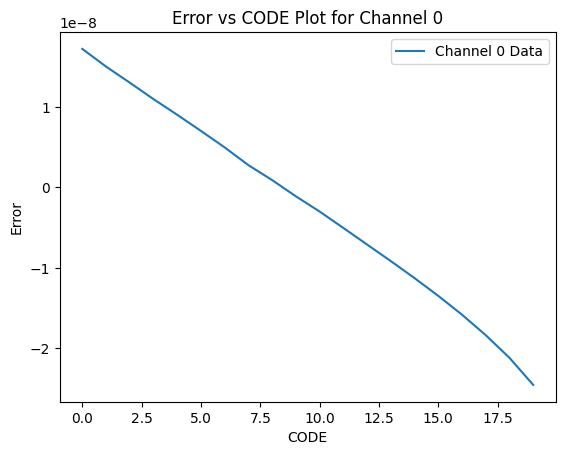

1
Writing data 1: 0x0
Measurement outputs: -5.64657e-06
Expected Output: -5.625e-06
Writing data 2: 0xd79
Measurement outputs: -5.05257e-06
Expected Output: -5.032939910888672e-06
Writing data 3: 0x1af2
Measurement outputs: -4.45878e-06
Expected Output: -4.440879821777344e-06
Writing data 4: 0x286b
Measurement outputs: -3.86492e-06
Expected Output: -3.8488197326660156e-06
Writing data 5: 0x35e4
Measurement outputs: -3.27121e-06
Expected Output: -3.2567596435546877e-06
Writing data 6: 0x435d
Measurement outputs: -2.67743e-06
Expected Output: -2.6646995544433594e-06
Writing data 7: 0x50d6
Measurement outputs: -2.08362e-06
Expected Output: -2.072639465332031e-06
Writing data 8: 0x5e4f
Measurement outputs: -1.48958e-06
Expected Output: -1.4805793762207031e-06
Writing data 9: 0x6bc8
Measurement outputs: -8.95895e-07
Expected Output: -8.88519287109375e-07
Writing data 10: 0x7941
Measurement outputs: -3.02087e-07
Expected Output: -2.964591979980469e-07
Writing data 11: 0x86ba
Measurement outp

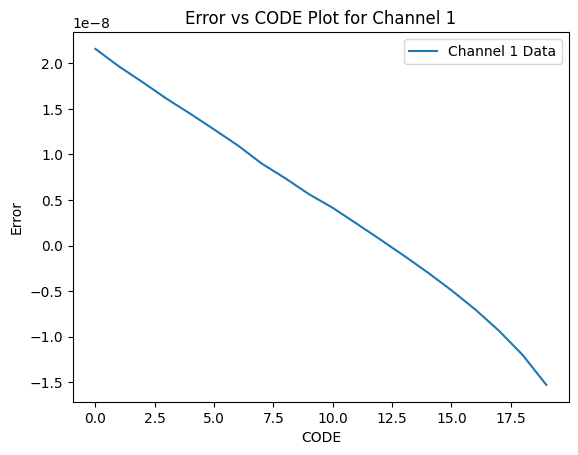

2
Writing data 1: 0x0
Measurement outputs: -5.63125e-06
Expected Output: -5.625e-06
Writing data 2: 0xd79
Measurement outputs: -5.03699e-06
Expected Output: -5.032939910888672e-06
Writing data 3: 0x1af2
Measurement outputs: -4.44295e-06
Expected Output: -4.440879821777344e-06
Writing data 4: 0x286b
Measurement outputs: -3.84885e-06
Expected Output: -3.8488197326660156e-06
Writing data 5: 0x35e4
Measurement outputs: -3.25489e-06
Expected Output: -3.2567596435546877e-06
Writing data 6: 0x435d
Measurement outputs: -2.66087e-06
Expected Output: -2.6646995544433594e-06
Writing data 7: 0x50d6
Measurement outputs: -2.06683e-06
Expected Output: -2.072639465332031e-06
Writing data 8: 0x5e4f
Measurement outputs: -1.47255e-06
Expected Output: -1.4805793762207031e-06
Writing data 9: 0x6bc8
Measurement outputs: -8.78632e-07
Expected Output: -8.88519287109375e-07
Writing data 10: 0x7941
Measurement outputs: -2.84617e-07
Expected Output: -2.964591979980469e-07
Writing data 11: 0x86ba
Measurement outp

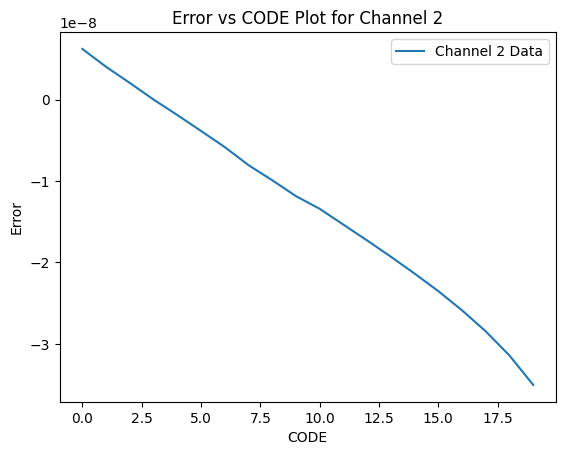

3
Writing data 1: 0x0
Measurement outputs: -5.63593e-06
Expected Output: -5.625e-06
Writing data 2: 0xd79
Measurement outputs: -5.042e-06
Expected Output: -5.032939910888672e-06
Writing data 3: 0x1af2
Measurement outputs: -4.44826e-06
Expected Output: -4.440879821777344e-06
Writing data 4: 0x286b
Measurement outputs: -3.85445e-06
Expected Output: -3.8488197326660156e-06
Writing data 5: 0x35e4
Measurement outputs: -3.26077e-06
Expected Output: -3.2567596435546877e-06
Writing data 6: 0x435d
Measurement outputs: -2.66703e-06
Expected Output: -2.6646995544433594e-06
Writing data 7: 0x50d6
Measurement outputs: -2.07329e-06
Expected Output: -2.072639465332031e-06
Writing data 8: 0x5e4f
Measurement outputs: -1.47932e-06
Expected Output: -1.4805793762207031e-06
Writing data 9: 0x6bc8
Measurement outputs: -8.85746e-07
Expected Output: -8.88519287109375e-07
Writing data 10: 0x7941
Measurement outputs: -2.92049e-07
Expected Output: -2.964591979980469e-07
Writing data 11: 0x86ba
Measurement output

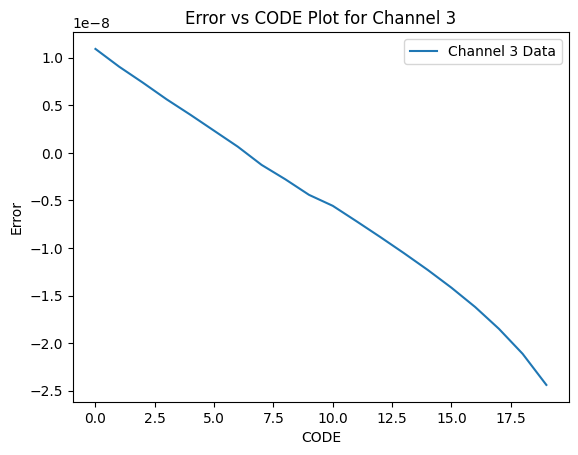


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT         Error
0      0x0        -0.000006    -0.000006  1.724000e-08
1    0xd79        -0.000005    -0.000005  1.504009e-08
2   0x1af2        -0.000004    -0.000004  1.304018e-08
3   0x286b        -0.000004    -0.000004  1.099027e-08
4   0x35e4        -0.000003    -0.000003  9.040356e-09
..     ...              ...          ...           ...
15  0xca17         0.000003     0.000003 -1.416866e-08
16  0xd790         0.000004     0.000004 -1.619857e-08
17  0xe509         0.000004     0.000004 -1.848849e-08
18  0xf282         0.000005     0.000005 -2.111840e-08
19  0xfffb         0.000006     0.000006 -2.438831e-08

[80 rows x 4 columns]


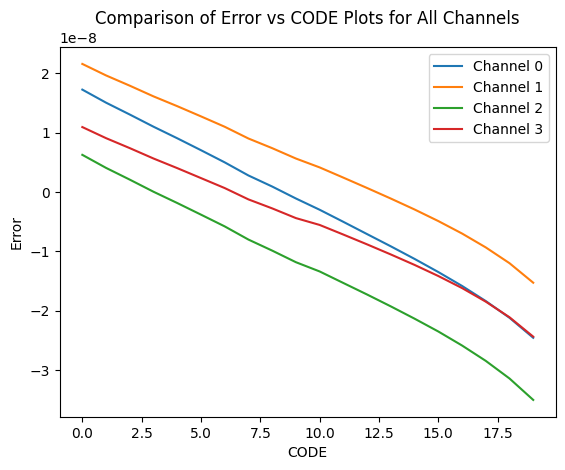

In [7]:

## Entire Program for FI - all 4 channels 5uA range


from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
    sleep(.5)

### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 10e-6
k.smua.source.limitv = 13
k.smua.measure.nplc         = 20
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})


for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })
    sleep(.5)

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,     # Channel enable
        "FORCE": 1,     # FI
        "SS0"  : 1,
        "SF0"  : 1,
        "C"    : 0,     # 5uA Range
        "FIN"  : 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for i in range(20):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=data,
            dac_reg="FIN_I_5u",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(.4)

        iv_data = -k.smua.measure.i()

        # Print the measurement outputs
        print(f"Measurement outputs: {iv_data}")

        # Calculate expected output and error
        IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (200*1000* 10) 
        error = IOUT - iv_data
        print(f"Expected Output: {IOUT}")
        data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    sleep(.5)
# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
plt.show()


In [1]:

## Entire Program for FI - all 4 channels 20uA range


from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
    sleep(.5)

### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 30e-6
k.smua.source.limitv = 13
k.smua.measure.nplc         = 20
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})


for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })
    sleep(.5)

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,     # Channel enable
        "FORCE": 1,     # FI
        "SS0"  : 1,
        "SF0"  : 1,
        "C"    : 1,     # 20uA Range
        "FIN"  : 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for i in range(20):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=data,
            dac_reg="FIN_I_20u",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(.4)

        iv_data = -k.smua.measure.i()

        # Print the measurement outputs
        print(f"Measurement outputs: {iv_data}")

        # Calculate expected output and error
        IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (50*1000* 10) 
        error = IOUT - iv_data
        print(f"Expected Output: {IOUT}")
        data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    sleep(.5)
# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
plt.show()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x9b in position 0: invalid start byte

0
Writing data 1: 0x0
Measurement outputs: -0.00022541
Expected Output: -0.000225
Writing data 2: 0xd79
Measurement outputs: -0.000201668
Expected Output: -0.00020131759643554688
Writing data 3: 0x1af2
Measurement outputs: -0.000177933
Expected Output: -0.00017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.000154195
Expected Output: -0.00015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.000130465
Expected Output: -0.0001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00010673
Expected Output: -0.00010658798217773438
Writing data 7: 0x50d6
Measurement outputs: -8.29942e-05
Expected Output: -8.290557861328125e-05
Writing data 8: 0x5e4f
Measurement outputs: -5.92521e-05
Expected Output: -5.9223175048828126e-05
Writing data 9: 0x6bc8
Measurement outputs: -3.55209e-05
Expected Output: -3.5540771484375e-05
Writing data 10: 0x7941
Measurement outputs: -1.17837e-05
Expected Output: -1.1858367919921875e-05
Writing data 11: 0x86ba
Measurement output

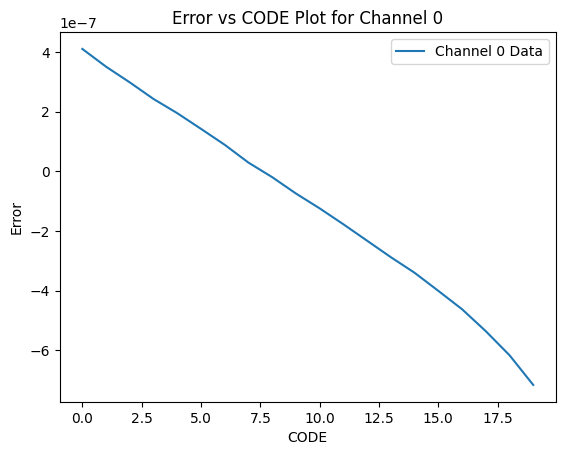

1
Writing data 1: 0x0
Measurement outputs: -0.000225673
Expected Output: -0.000225
Writing data 2: 0xd79
Measurement outputs: -0.000201934
Expected Output: -0.00020131759643554688
Writing data 3: 0x1af2
Measurement outputs: -0.000178201
Expected Output: -0.00017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.000154465
Expected Output: -0.00015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.000130736
Expected Output: -0.0001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.000107002
Expected Output: -0.00010658798217773438
Writing data 7: 0x50d6
Measurement outputs: -8.32676e-05
Expected Output: -8.290557861328125e-05
Writing data 8: 0x5e4f
Measurement outputs: -5.95247e-05
Expected Output: -5.9223175048828126e-05
Writing data 9: 0x6bc8
Measurement outputs: -3.57935e-05
Expected Output: -3.5540771484375e-05
Writing data 10: 0x7941
Measurement outputs: -1.20565e-05
Expected Output: -1.1858367919921875e-05
Writing data 11: 0x86ba
Measurement outp

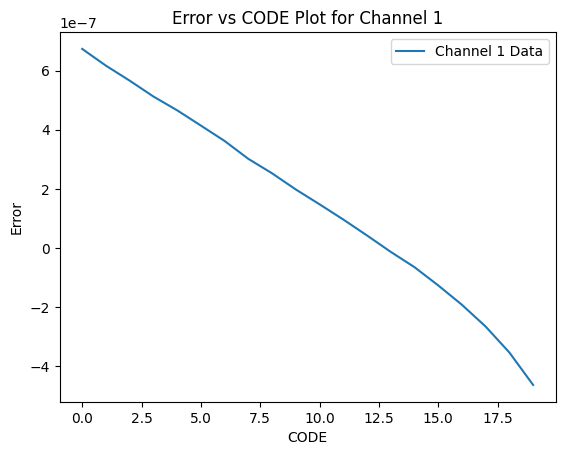

2
Writing data 1: 0x0
Measurement outputs: -0.000224964
Expected Output: -0.000225
Writing data 2: 0xd79
Measurement outputs: -0.000201225
Expected Output: -0.00020131759643554688
Writing data 3: 0x1af2
Measurement outputs: -0.000177494
Expected Output: -0.00017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.000153757
Expected Output: -0.00015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.000130027
Expected Output: -0.0001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.000106293
Expected Output: -0.00010658798217773438
Writing data 7: 0x50d6
Measurement outputs: -8.25562e-05
Expected Output: -8.290557861328125e-05
Writing data 8: 0x5e4f
Measurement outputs: -5.88101e-05
Expected Output: -5.9223175048828126e-05
Writing data 9: 0x6bc8
Measurement outputs: -3.50767e-05
Expected Output: -3.5540771484375e-05
Writing data 10: 0x7941
Measurement outputs: -1.13394e-05
Expected Output: -1.1858367919921875e-05
Writing data 11: 0x86ba
Measurement outp

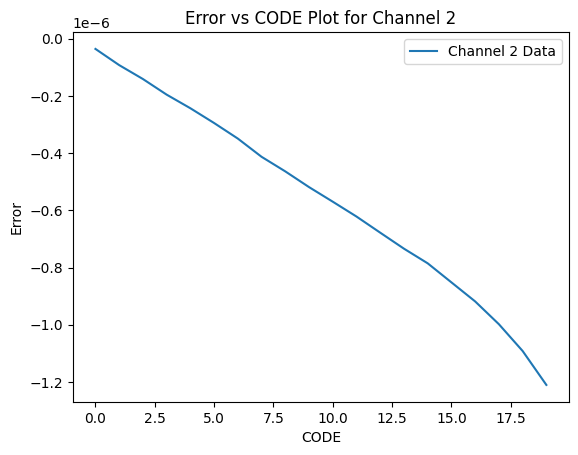

3
Writing data 1: 0x0
Measurement outputs: -0.000225133
Expected Output: -0.000225
Writing data 2: 0xd79
Measurement outputs: -0.000201405
Expected Output: -0.00020131759643554688
Writing data 3: 0x1af2
Measurement outputs: -0.000177688
Expected Output: -0.00017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.000153966
Expected Output: -0.00015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.000130248
Expected Output: -0.0001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.000106529
Expected Output: -0.00010658798217773438
Writing data 7: 0x50d6
Measurement outputs: -8.28093e-05
Expected Output: -8.290557861328125e-05
Writing data 8: 0x5e4f
Measurement outputs: -5.90775e-05
Expected Output: -5.9223175048828126e-05
Writing data 9: 0x6bc8
Measurement outputs: -3.53597e-05
Expected Output: -3.5540771484375e-05
Writing data 10: 0x7941
Measurement outputs: -1.16349e-05
Expected Output: -1.1858367919921875e-05
Writing data 11: 0x86ba
Measurement outp

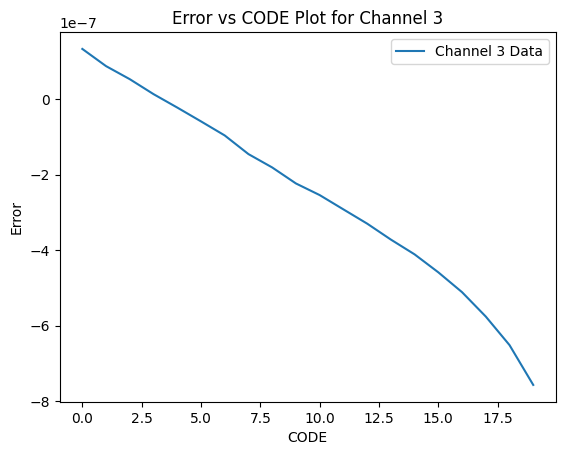


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT         Error
0      0x0        -0.000225    -0.000225  4.100000e-07
1    0xd79        -0.000201    -0.000202  3.504036e-07
2   0x1af2        -0.000178    -0.000178  2.978071e-07
3   0x286b        -0.000154    -0.000154  2.422107e-07
4   0x35e4        -0.000130    -0.000130  1.946143e-07
..     ...              ...          ...           ...
15  0xca17         0.000130     0.000131 -4.589465e-07
16  0xd790         0.000154     0.000154 -5.115430e-07
17  0xe509         0.000178     0.000178 -5.761394e-07
18  0xf282         0.000201     0.000202 -6.517358e-07
19  0xfffb         0.000225     0.000226 -7.573323e-07

[80 rows x 4 columns]


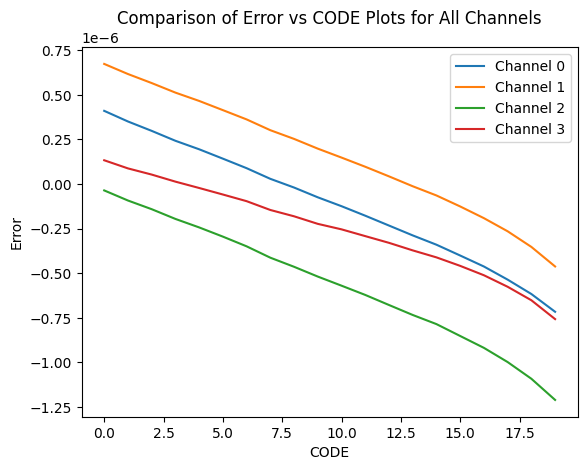

In [1]:

## Entire Program for FI - all 4 channels 200uA range


from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
    sleep(.5)

### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 300e-6
k.smua.source.limitv = 13
k.smua.measure.nplc         = 30
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})


for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })
    sleep(.5)

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,     # Channel enable
        "FORCE": 1,     # FI
        "SS0"  : 1,
        "SF0"  : 1,
        "C"    : 2,     # 200uA Range
        "FIN"  : 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for i in range(20):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=data,
            dac_reg="FIN_I_200u",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(.4)

        iv_data = -k.smua.measure.i()

        # Print the measurement outputs
        print(f"Measurement outputs: {iv_data}")

        # Calculate expected output and error
        IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (5*1000* 10) 
        error = IOUT - iv_data
        print(f"Expected Output: {IOUT}")
        data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    sleep(.5)
# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
plt.show()


0
Writing data 1: 0x0
Measurement outputs: -0.00225339
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201603
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177887
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154159
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130434
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106719
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000830367
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000593047
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000355867
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.00011863
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001185

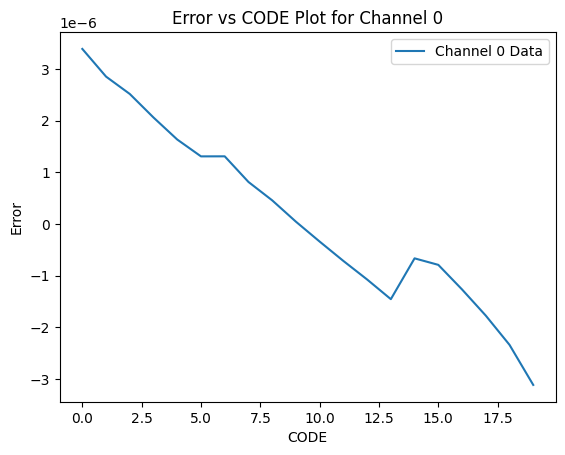

1
Writing data 1: 0x0
Measurement outputs: -0.00225662
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.0020193
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00178204
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154473
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130744
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00107018
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000833379
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000595956
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000358712
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000121415
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001157

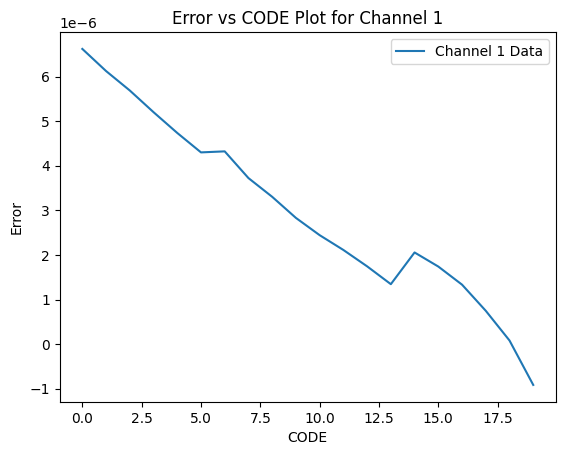

2
Writing data 1: 0x0
Measurement outputs: -0.00224972
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201241
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.0017751
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00153785
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130067
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106337
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000826482
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000589048
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000351802
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000114514
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001226

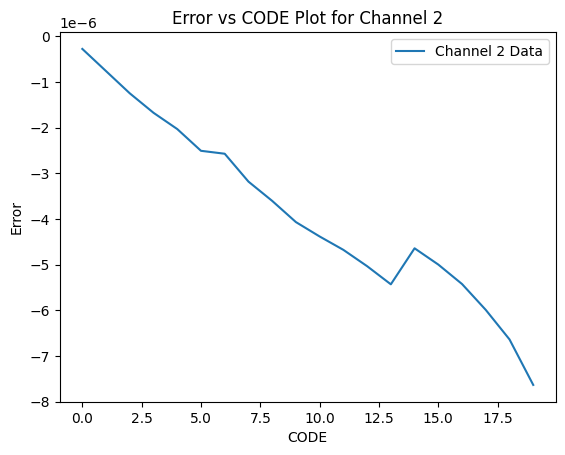

3
Writing data 1: 0x0
Measurement outputs: -0.00225163
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201435
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177723
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154009
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130298
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106582
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000829023
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000591726
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000354556
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000117362
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.000119

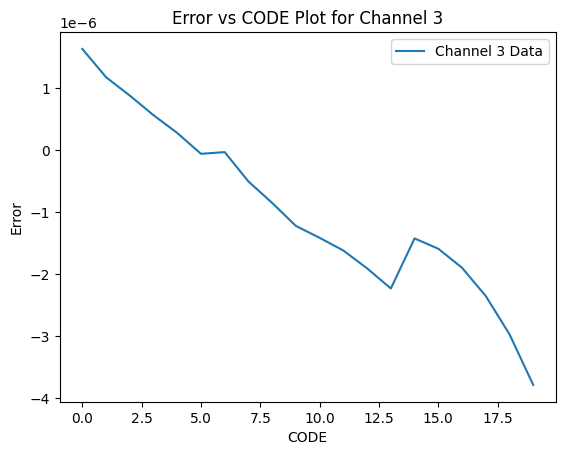


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT     Error
0      0x0        -0.002250    -0.002253  0.000003
1    0xd79        -0.002013    -0.002016  0.000003
2   0x1af2        -0.001776    -0.001779  0.000003
3   0x286b        -0.001540    -0.001542  0.000002
4   0x35e4        -0.001303    -0.001304  0.000002
..     ...              ...          ...       ...
15  0xca17         0.001302     0.001304 -0.000002
16  0xd790         0.001539     0.001541 -0.000002
17  0xe509         0.001776     0.001778 -0.000002
18  0xf282         0.002013     0.002016 -0.000003
19  0xfffb         0.002250     0.002253 -0.000004

[80 rows x 4 columns]


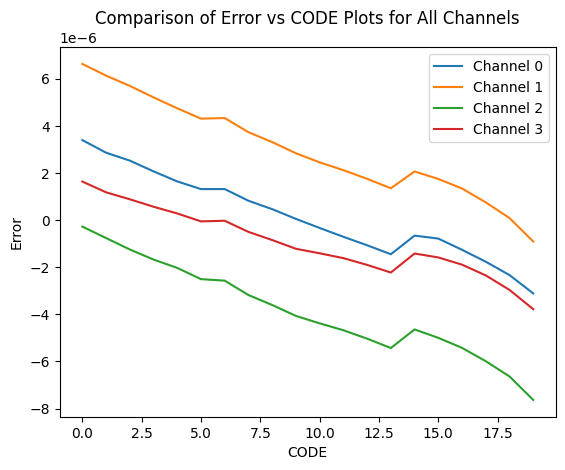

In [5]:

## Entire Program for FI - all 4 channels 2mA range


from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
    sleep(.5)

### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 3e-3
k.smua.source.limitv = 13
k.smua.measure.nplc         = 30
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})


for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })
    sleep(.5)

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,     # Channel enable
        "FORCE": 1,     # FI
        "SS0"  : 1,
        "SF0"  : 1,
        "C"    : 3,     # 20mA Range
        "FIN"  : 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for i in range(20):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=data,
            dac_reg="FIN_I_2m",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(.4)

        iv_data = -k.smua.measure.i()

        # Print the measurement outputs
        print(f"Measurement outputs: {iv_data}")

        # Calculate expected output and error
        IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (500* 10) 
        error = IOUT - iv_data
        print(f"Expected Output: {IOUT}")
        data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    sleep(.5)
# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
plt.show()


0
Writing data 1: 0x0
Measurement outputs: -0.0750368
Expected Output: -0.075
Writing data 2: 0x295
Measurement outputs: -0.0735238
Expected Output: -0.07348709106445313
Writing data 3: 0x52a
Measurement outputs: -0.0720098
Expected Output: -0.07197418212890624
Writing data 4: 0x7bf
Measurement outputs: -0.0704958
Expected Output: -0.07046127319335938
Writing data 5: 0xa54
Measurement outputs: -0.0689817
Expected Output: -0.0689483642578125
Writing data 6: 0xce9
Measurement outputs: -0.067468
Expected Output: -0.06743545532226562
Writing data 7: 0xf7e
Measurement outputs: -0.0659538
Expected Output: -0.06592254638671875
Writing data 8: 0x1213
Measurement outputs: -0.0644403
Expected Output: -0.06440963745117187
Writing data 9: 0x14a8
Measurement outputs: -0.0629255
Expected Output: -0.062896728515625
Writing data 10: 0x173d
Measurement outputs: -0.0614113
Expected Output: -0.061383819580078124
Writing data 11: 0x19d2
Measurement outputs: -0.0598982
Expected Output: -0.05987091064453125

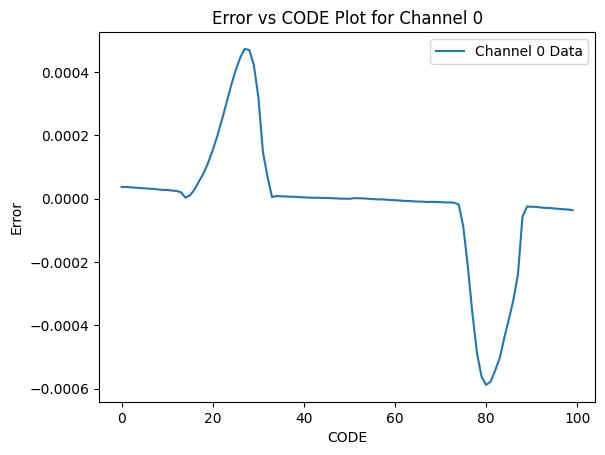

1
Writing data 1: 0x0
Measurement outputs: -0.0751425
Expected Output: -0.075
Writing data 2: 0x295
Measurement outputs: -0.0736297
Expected Output: -0.07348709106445313
Writing data 3: 0x52a
Measurement outputs: -0.0721145
Expected Output: -0.07197418212890624
Writing data 4: 0x7bf
Measurement outputs: -0.0706002
Expected Output: -0.07046127319335938
Writing data 5: 0xa54
Measurement outputs: -0.0690863
Expected Output: -0.0689483642578125
Writing data 6: 0xce9
Measurement outputs: -0.0675726
Expected Output: -0.06743545532226562
Writing data 7: 0xf7e
Measurement outputs: -0.066058
Expected Output: -0.06592254638671875
Writing data 8: 0x1213
Measurement outputs: -0.0645445
Expected Output: -0.06440963745117187
Writing data 9: 0x14a8
Measurement outputs: -0.0630299
Expected Output: -0.062896728515625
Writing data 10: 0x173d
Measurement outputs: -0.0615153
Expected Output: -0.061383819580078124
Writing data 11: 0x19d2
Measurement outputs: -0.060002
Expected Output: -0.05987091064453125


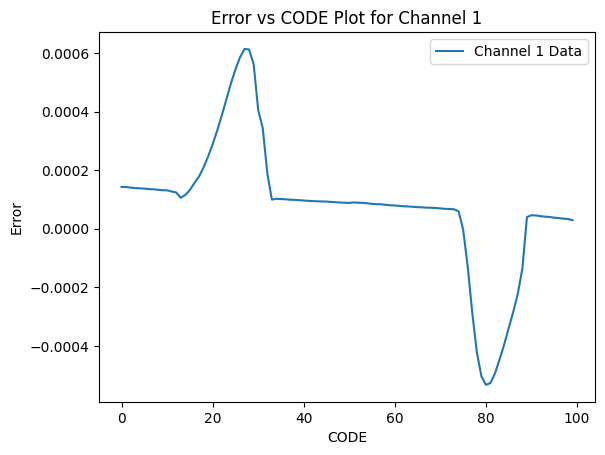

2
Writing data 1: 0x0
Measurement outputs: -0.0749072
Expected Output: -0.075
Writing data 2: 0x295
Measurement outputs: -0.0733939
Expected Output: -0.07348709106445313
Writing data 3: 0x52a
Measurement outputs: -0.0718795
Expected Output: -0.07197418212890624
Writing data 4: 0x7bf
Measurement outputs: -0.0703652
Expected Output: -0.07046127319335938
Writing data 5: 0xa54
Measurement outputs: -0.0688509
Expected Output: -0.0689483642578125
Writing data 6: 0xce9
Measurement outputs: -0.0673368
Expected Output: -0.06743545532226562
Writing data 7: 0xf7e
Measurement outputs: -0.0658223
Expected Output: -0.06592254638671875
Writing data 8: 0x1213
Measurement outputs: -0.0643086
Expected Output: -0.06440963745117187
Writing data 9: 0x14a8
Measurement outputs: -0.0627934
Expected Output: -0.062896728515625
Writing data 10: 0x173d
Measurement outputs: -0.0612792
Expected Output: -0.061383819580078124
Writing data 11: 0x19d2
Measurement outputs: -0.0597658
Expected Output: -0.0598709106445312

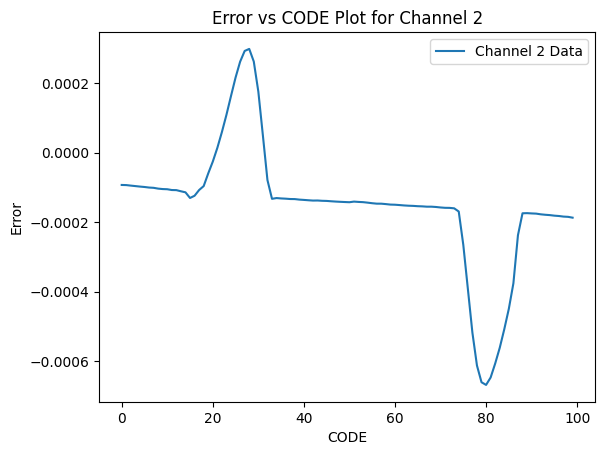

3
Writing data 1: 0x0
Measurement outputs: -0.0749203
Expected Output: -0.075
Writing data 2: 0x295
Measurement outputs: -0.0734085
Expected Output: -0.07348709106445313
Writing data 3: 0x52a
Measurement outputs: -0.0718954
Expected Output: -0.07197418212890624
Writing data 4: 0x7bf
Measurement outputs: -0.0703828
Expected Output: -0.07046127319335938
Writing data 5: 0xa54
Measurement outputs: -0.0688704
Expected Output: -0.0689483642578125
Writing data 6: 0xce9
Measurement outputs: -0.0673581
Expected Output: -0.06743545532226562
Writing data 7: 0xf7e
Measurement outputs: -0.065845
Expected Output: -0.06592254638671875
Writing data 8: 0x1213
Measurement outputs: -0.0643326
Expected Output: -0.06440963745117187
Writing data 9: 0x14a8
Measurement outputs: -0.0628193
Expected Output: -0.062896728515625
Writing data 10: 0x173d
Measurement outputs: -0.0613056
Expected Output: -0.061383819580078124
Writing data 11: 0x19d2
Measurement outputs: -0.0597937
Expected Output: -0.05987091064453125

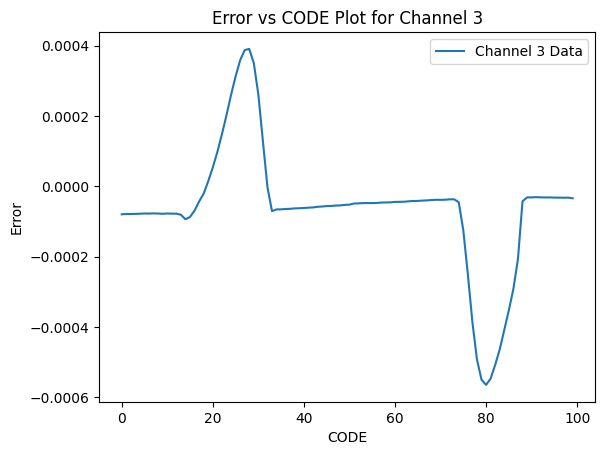


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT     Error
0      0x0        -0.075000    -0.075037  0.000037
1    0x295        -0.073487    -0.073524  0.000037
2    0x52a        -0.071974    -0.072010  0.000036
3    0x7bf        -0.070461    -0.070496  0.000035
4    0xa54        -0.068948    -0.068982  0.000033
..     ...              ...          ...       ...
95  0xf54b         0.068726     0.068759 -0.000032
96  0xf7e0         0.070239     0.070271 -0.000032
97  0xfa75         0.071752     0.071785 -0.000032
98  0xfd0a         0.073265     0.073297 -0.000032
99  0xff9f         0.074778     0.074812 -0.000034

[400 rows x 4 columns]


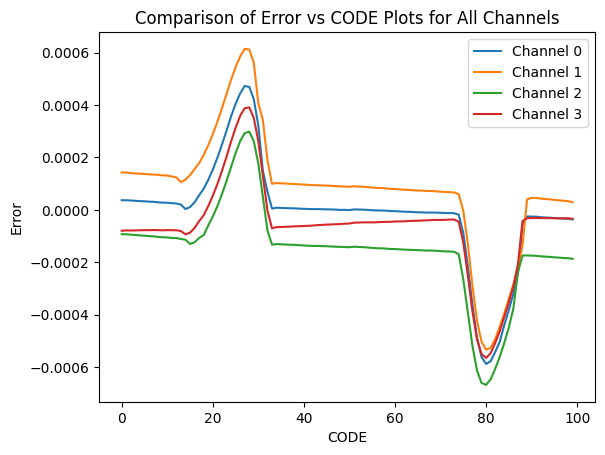

In [7]:

## Entire Program for FI - all 4 channels Ext(80mA) range


from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smub.OUTPUT_OFF

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
    sleep(.5)

### AMP - MODE

p.write_all_PMU_REGS(0x1E060)

# k.smua.source.func = k.smua.OUTPUT_DCAMPS
k.smua.source.func = k.smua.OUTPUT_DCVOLTS
k.smua.source.levelv = 0
k.smua.source.limiti = 90e-3
k.smua.source.limitv = 13
k.smua.measure.nplc         = 30
# k.smua.source.output = k.smua.OUTPUT_OFF
k.smua.source.output = k.smua.OUTPUT_ON

p.change_sys_ctrl({
    "DUTGND/CH" : 1,
    "INT10K"    : 1,
    "TMP ENABLE": 1,
    "TMP"       : 3 # Thermal shutdown at 100°C
})


for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })
    sleep(.5)

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
    
    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,     # Channel enable
        "FORCE": 1,     # FI
        "SS0"  : 1,
        "SF0"  : 1,
        "C"    : 4,     # ext Range
        "FIN"  : 1
    })

    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF

    data_list = []

    # Calculate the step size to generate 20 equidistant data points
    step_size = 0xFFFF // 99

    # Loop to generate and write equidistant data points
    for i in range(100):
        # Calculate the data value for the current index
        data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {i + 1}: {hex(data)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=data,
            dac_reg="FIN_I_ext",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(.4)

        iv_data = -k.smua.measure.i()

        # Print the measurement outputs
        print(f"Measurement outputs: {iv_data}")

        # Calculate expected output and error
        IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (15* 10) 
        error = IOUT - iv_data
        print(f"Expected Output: {IOUT}")
        data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()
    plt.show()

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    sleep(.5)
# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
plt.show()


In [26]:


                                            #        INITIAL PMU SETUP





# p.write_all_PMU_REGS(0X1E060)

# k.display.screen            = k.display.SMUA
# k.display.smua.measure.func = k.display.MEASURE_DCAMPS

# k.smua.measure.autorangev = k.smua.AUTORANGE_ON
# k.smua.measure.autorangei   = k.smua.AUTORANGE_ON
# k.smua.measure.nplc         = 30
    
# k.smua.source.func          = k.smua.OUTPUT_DCVOLTS
# k.smua.source.levelv        = 0
# k.smua.source.limiti        = 100e-3
# k.smua.source.limitv        = 13
# k.smua.source.output        = k.smua.OUTPUT_ON

# p.channels[0].change_pmu_reg({
#     "CH EN": 1,     #Channel enable
#     "FORCE": 1,     #FI
#     "SS0"  : 1,
#     "SF0"  : 1,
#     # "C"    : 0,     #5uA Range
#     # "C"    : 1,     #20uA Range
#     # "C"    : 2,     #200uA Range
#     # "C"    : 3,     #2mA Range
#     "C"    : 3,     #80mA Range
#     "FIN"  : 1
# })

# p.change_sys_ctrl({
#     "DUTGND/CH" : 1,
#     "INT10K"    : 1,
#     "TMP ENABLE": 1,
#     "TMP"       : 3, # Thermal shutdown at 100°C
#     "GAIN"      : 2
    
# })



Writing data 1: 0x0
Measurement outputs : -0.00225401
Expected Output :-0.00225
Writing data 2: 0xd79
Measurement outputs : -0.00201669
Expected Output :-0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs : -0.00177946
Expected Output :-0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs : -0.00154217
Expected Output :-0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs : -0.00130495
Expected Output :-0.001302703857421875
Writing data 6: 0x435d
Measurement outputs : -0.00106777
Expected Output :-0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs : -0.000830455
Expected Output :-0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs : -0.000593053
Expected Output :-0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs : -0.000355798
Expected Output :-0.00035540771484375
Writing data 10: 0x7941
Measurement outputs : -0.000118542
Expected Output :-0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs :

<Axes: >

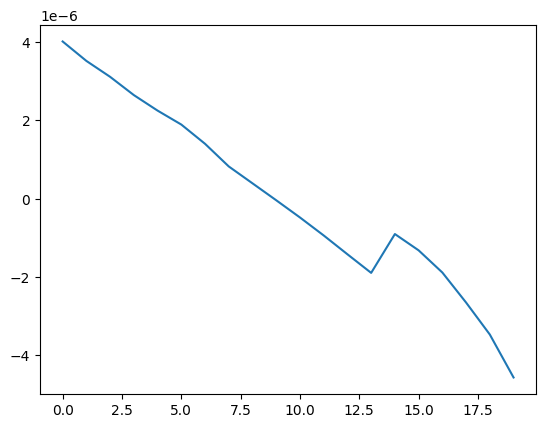

In [10]:
#####


                                     # PROGRAM FOR FI FOR A SINGLE CHANNEL FROM 0x0000 to 0xFFFF  





# p.channels[0].change_pmu_reg({
#     "CH EN": 1,     #Channel enable
#     "FORCE": 1,     #FI
#     "SS0"  : 1,
#     "SF0"  : 1,
#     # "C"    : 0,     #5uA Range
#     # "C"    : 1,     #20uA Range
#     # "C"    : 2,     #200uA Range
#     # "C"    : 3,     #2mA Range
#     "C"    : 3,     #80mA Range
#     "FIN"  : 1
# })




# data_list = []

# # Calculate the step size to generate 20 equidistant data points
# step_size = 0xFFFF // 19

# # Loop to generate and write equidistant data points
# for i in range(20):
#     # Calculate the data value for the current index
#     data = i * step_size
    
#     # Print the data being written to the DAC register
#     print(f"Writing data {i + 1}: {hex(data)}")
    
#     # Write the data to the DAC register
#     p.channels[0].write_dac(
#         data=data,
#         dac_reg="FIN_I_2m",
#     reg="X1"
#     )
    
#     # Perform measurement after writing to the DAC register
#     sleep(1)
    
#     iv_data = -k.smua.measure.i()
    
#     # Print the measurement outputs
#     print(f"Measurement outputs : {iv_data}")

#     IOUT =  4.5 * 5 * ((int(data) - 2**15) / 2**16) / (500 * 10)
#     error = IOUT - iv_data
#     print(f"Expected Output :{ IOUT}")
#     data_list.append({"CODE":hex(data),"IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

# data_df = pd.DataFrame(data_list)

# # Display the DataFrame
# print("\nData stored in DataFrame:")
# print(data_df)
# data_df["Error"].plot()

0
Writing data 1: 0x0
Measurement outputs: -0.00225332
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201606
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177886
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154166
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130445
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106731
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000830432
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000593117
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000355855
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000118621
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.000118

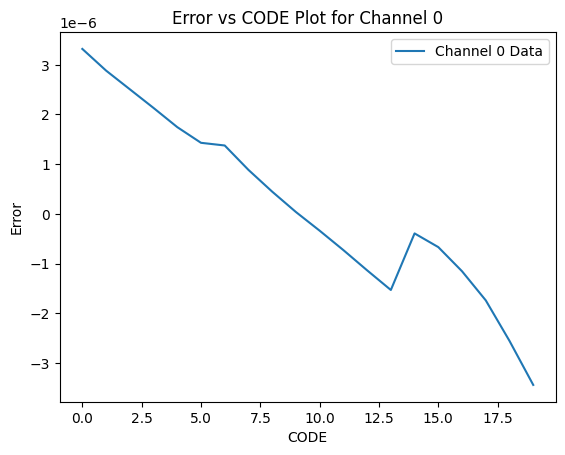

1
Writing data 1: 0x0
Measurement outputs: -0.00225653
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201921
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00178197
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154476
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130764
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00107036
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000833443
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000596092
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000358736
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000121427
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.000115

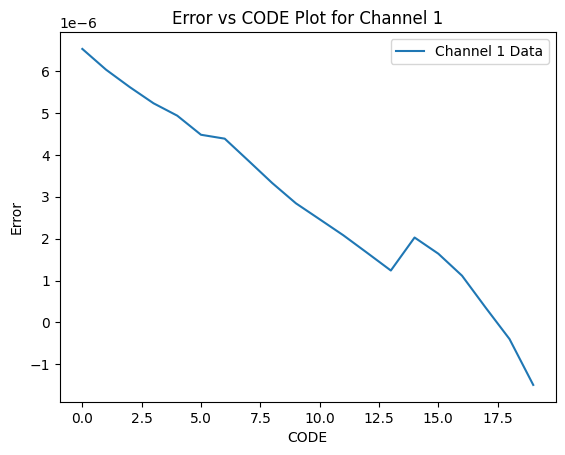

2
Writing data 1: 0x0
Measurement outputs: -0.00224962
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201235
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177512
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00153789
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130072
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106341
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000826466
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000589166
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000351822
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000114504
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.000122

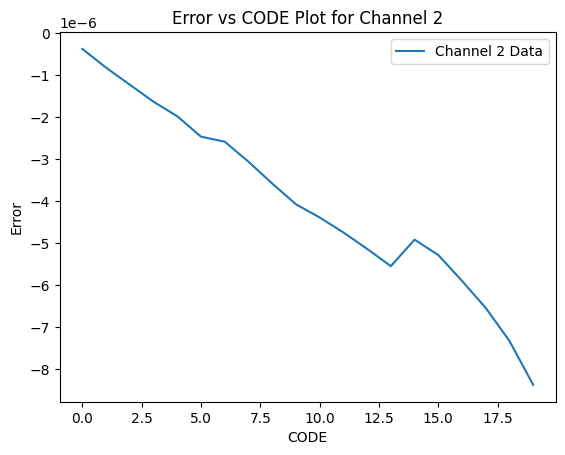

3
Writing data 1: 0x0
Measurement outputs: -0.00225163
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201443
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177727
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154013
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130302
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106588
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000828996
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000591833
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000354614
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.00011739
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001196

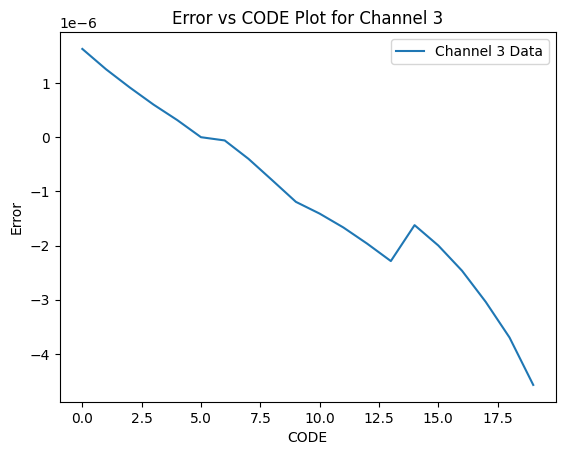


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT     Error
0      0x0        -0.002250    -0.002253  0.000003
1    0xd79        -0.002013    -0.002016  0.000003
2   0x1af2        -0.001776    -0.001779  0.000003
3   0x286b        -0.001540    -0.001542  0.000002
4   0x35e4        -0.001303    -0.001304  0.000002
..     ...              ...          ...       ...
15  0xca17         0.001302     0.001304 -0.000002
16  0xd790         0.001539     0.001542 -0.000002
17  0xe509         0.001776     0.001779 -0.000003
18  0xf282         0.002013     0.002017 -0.000004
19  0xfffb         0.002250     0.002254 -0.000005

[80 rows x 4 columns]


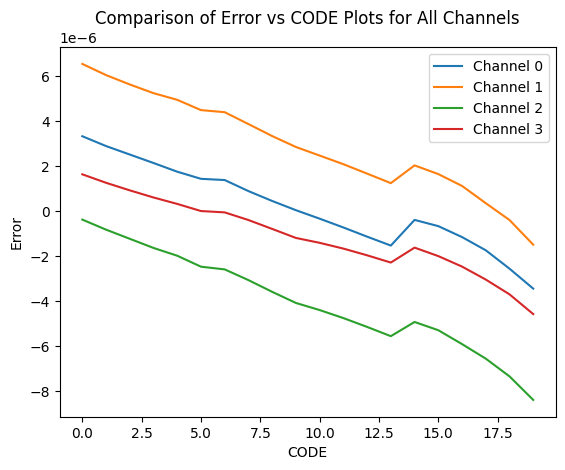

In [7]:

# ## Entire Program for FI - all 4 channels 2mA range


# from keithley2600 import Keithley2600
# from pmu_som import communicator, pmu_ctrl, pmu_cal
# from time import sleep
# import numpy as np
# from matplotlib import pyplot as plt
# from tqdm import tqdm
# import pandas as pd


# try:
#     del(p.c)
# except:
#     pass

# k = Keithley2600('GPIB0::17::INSTR', visa_library='')

# k.smua.reset()
# k.smub.reset()

# # p = communicator.communicator(False)
# p = pmu_ctrl.pmu()

# k.smua.source.output = k.smua.OUTPUT_OFF
# k.smua.source.output = k.smub.OUTPUT_OFF

# ### all channels of PMU turnoff

# for channel in p.channels:
#     channel.change_pmu_reg({"CH EN": 0})

# ### AMP - MODE

# p.write_all_PMU_REGS(0x1E060)

# # k.smua.source.func = k.smua.OUTPUT_DCAMPS
# k.smua.source.func = k.smua.OUTPUT_DCVOLTS
# k.smua.source.levelv = 0
# k.smua.source.limiti = 10e-3
# k.smua.source.limitv = 13
# k.smua.measure.nplc         = 30
# # k.smua.source.output = k.smua.OUTPUT_OFF
# k.smua.source.output = k.smua.OUTPUT_ON

# p.change_sys_ctrl({
#     "DUTGND/CH" : 1,
#     "INT10K"    : 1,
#     "TMP ENABLE": 1,
#     "TMP"       : 3 # Thermal shutdown at 100°C
# })


# for ch in range(4):
#     p.channels[ch].change_pmu_reg({

#     "SS0"   : 0,
#     "SF0"   : 0,#1,1

#     })

# import pandas as pd
# import matplotlib.pyplot as plt

# # Initialize an empty list to store individual DataFrames
# all_dataframes = []

# # Add for loop for ch
# for ch in range(4):
#     print(ch)
    
#     # Change PMU register settings for the current channel
#     p.channels[ch].change_pmu_reg({
#         "CH EN": 1,     # Channel enable
#         "FORCE": 1,     # FI
#         "SS0"  : 1,
#         "SF0"  : 1,
#         "C"    : 3,     # 2mA Range
#         "FIN"  : 1
#     })

#     # Enable beeper and play chord
#     k.beeper.enable = k.beeper.ON
#     k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
#     k.beeper.enable = k.beeper.OFF

#     data_list = []

#     # Calculate the step size to generate 20 equidistant data points
#     step_size = 0xFFFF // 19

#     # Loop to generate and write equidistant data points
#     for i in range(20):
#         # Calculate the data value for the current index
#         data = i * step_size

#         # Print the data being written to the DAC register
#         print(f"Writing data {i + 1}: {hex(data)}")

#         # Write the data to the DAC register
#         p.channels[ch].write_dac(
#             data=data,
#             dac_reg="FIN_I_2m",
#             reg="X1"
#         )

#         # Perform measurement after writing to the DAC register
#         sleep(1)

#         iv_data = -k.smua.measure.i()

#         # Print the measurement outputs
#         print(f"Measurement outputs: {iv_data}")

#         # Calculate expected output and error
#         IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (500 * 10) 
#         error = IOUT - iv_data
#         print(f"Expected Output: {IOUT}")
#         data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

#     # Create a DataFrame for the current channel
#     data_df = pd.DataFrame(data_list)

#     # Append the DataFrame to the list of all DataFrames
#     all_dataframes.append(data_df)

#     # Display the DataFrame
#     print("\nData stored in DataFrame:")
#     print(data_df)

#     # Plot the data for the current channel
#     plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
#     plt.xlabel("CODE")
#     plt.ylabel("Error")
#     plt.title(f"Error vs CODE Plot for Channel {ch}")
#     plt.legend()
#     plt.show()

#     # Change PMU register settings for the current channel
#     p.channels[ch].change_pmu_reg({
#         "SS0": 0,
#         "SF0": 0,
#     })

# # Concatenate all individual DataFrames into a single DataFrame
# all_data_df = pd.concat(all_dataframes)

# # Display the new DataFrame
# print("\nNew DataFrame containing values of all four previous DataFrames:")
# print(all_data_df)

# # Plot comparing all the other four plots
# for df in all_dataframes:
#     plt.plot(df.index, df["Error"], linestyle='-')

# plt.xlabel("CODE")
# plt.ylabel("Error")
# plt.title("Comparison of Error vs CODE Plots for All Channels")
# plt.legend([f"Channel {i}" for i in range(4)])
# plt.show()


0
Writing data 1: 0x0
Measurement outputs: -0.00225343
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201627
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177902
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.0015418
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130464
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106747
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000830437
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000593123
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000355871
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000118634
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001185

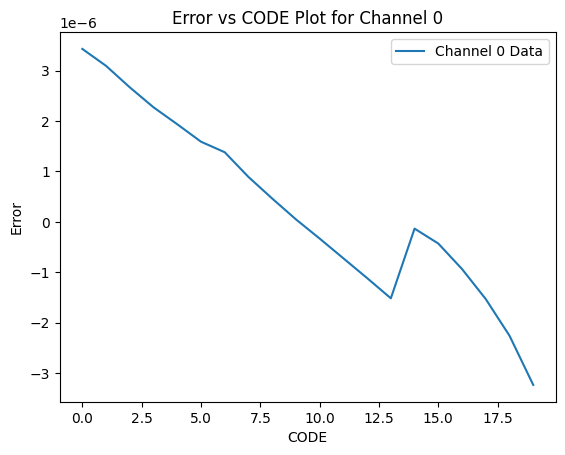

1
Writing data 1: 0x0
Measurement outputs: -0.00225678
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201942
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00178217
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154492
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130772
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00107049
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000833435
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000596089
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000358728
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.00012142
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.0001157

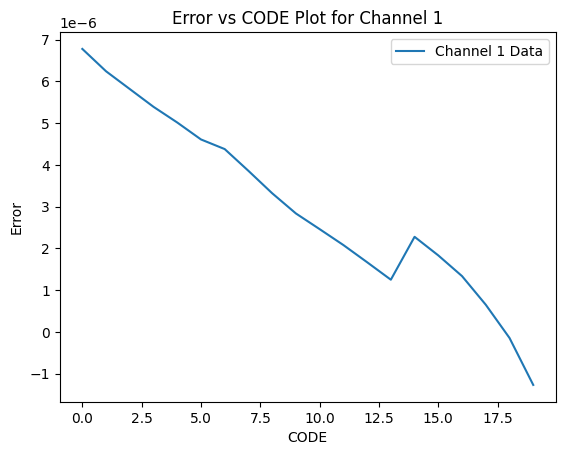

2
Writing data 1: 0x0
Measurement outputs: -0.00224976
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201241
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177529
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00153799
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130085
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106355
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000826469
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.00058917
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.00035182
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000114506
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.00012263

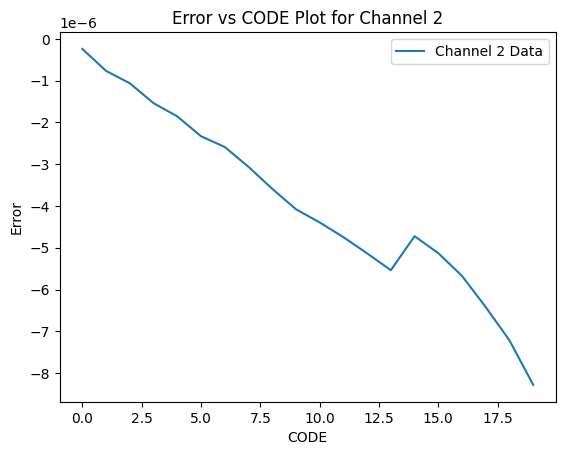

3
Writing data 1: 0x0
Measurement outputs: -0.00225172
Expected Output: -0.00225
Writing data 2: 0xd79
Measurement outputs: -0.00201447
Expected Output: -0.0020131759643554686
Writing data 3: 0x1af2
Measurement outputs: -0.00177739
Expected Output: -0.0017763519287109376
Writing data 4: 0x286b
Measurement outputs: -0.00154029
Expected Output: -0.0015395278930664062
Writing data 5: 0x35e4
Measurement outputs: -0.00130319
Expected Output: -0.001302703857421875
Writing data 6: 0x435d
Measurement outputs: -0.00106605
Expected Output: -0.0010658798217773437
Writing data 7: 0x50d6
Measurement outputs: -0.000828974
Expected Output: -0.0008290557861328125
Writing data 8: 0x5e4f
Measurement outputs: -0.000591821
Expected Output: -0.0005922317504882812
Writing data 9: 0x6bc8
Measurement outputs: -0.000354605
Expected Output: -0.00035540771484375
Writing data 10: 0x7941
Measurement outputs: -0.000117386
Expected Output: -0.00011858367919921874
Writing data 11: 0x86ba
Measurement outputs: 0.000119

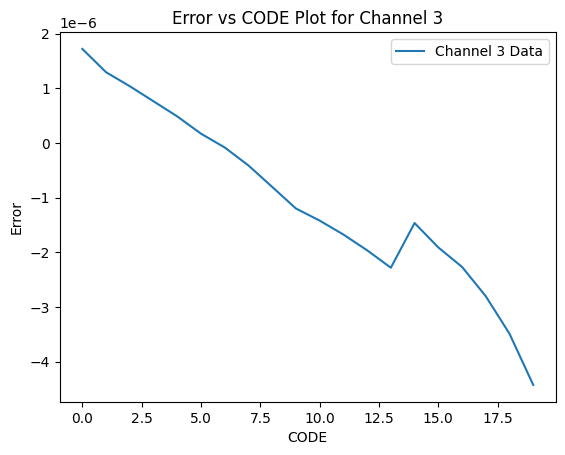


New DataFrame containing values of all four previous DataFrames:
      CODE  IOUT - EXPECTED  IOUT-RESULT     Error
0      0x0        -0.002250    -0.002253  0.000003
1    0xd79        -0.002013    -0.002016  0.000003
2   0x1af2        -0.001776    -0.001779  0.000003
3   0x286b        -0.001540    -0.001542  0.000002
4   0x35e4        -0.001303    -0.001305  0.000002
..     ...              ...          ...       ...
15  0xca17         0.001302     0.001304 -0.000002
16  0xd790         0.001539     0.001541 -0.000002
17  0xe509         0.001776     0.001779 -0.000003
18  0xf282         0.002013     0.002016 -0.000003
19  0xfffb         0.002250     0.002254 -0.000004

[80 rows x 4 columns]


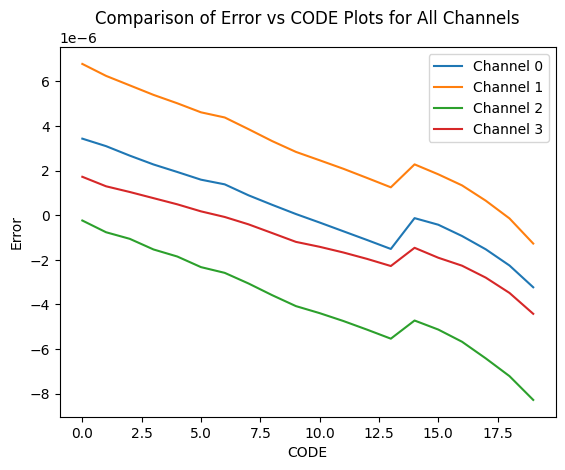

In [45]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Initialize an empty list to store individual DataFrames
# all_dataframes = []

# # Add for loop for ch
# for ch in range(4):
#     print(ch)
    
#     # Change PMU register settings for the current channel
#     p.channels[ch].change_pmu_reg({
#         "CH EN": 1,     # Channel enable
#         "FORCE": 1,     # FI
#         "SS0"  : 1,
#         "SF0"  : 1,
#         "C"    : 3,     # 2mA Range
#         "FIN"  : 1
#     })

#     # Enable beeper and play chord
#     k.beeper.enable = k.beeper.ON
#     k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
#     k.beeper.enable = k.beeper.OFF

#     data_list = []

#     # Calculate the step size to generate 20 equidistant data points
#     step_size = 0xFFFF // 19

#     # Loop to generate and write equidistant data points
#     for i in range(20):
#         # Calculate the data value for the current index
#         data = i * step_size

#         # Print the data being written to the DAC register
#         print(f"Writing data {i + 1}: {hex(data)}")

#         # Write the data to the DAC register
#         p.channels[ch].write_dac(
#             data=data,
#             dac_reg="FIN_I_2m",
#             reg="X1"
#         )

#         # Perform measurement after writing to the DAC register
#         sleep(1)

#         iv_data = -k.smua.measure.i()

#         # Print the measurement outputs
#         print(f"Measurement outputs: {iv_data}")

#         # Calculate expected output and error
#         IOUT = 4.5 * 5 * ((int(data) - 2**15) / 2**16) / (200*10e3 * 10) 
#         error = IOUT - iv_data
#         print(f"Expected Output: {IOUT}")
#         data_list.append({"CODE": hex(data), "IOUT - EXPECTED": IOUT, "IOUT-RESULT": iv_data, "Error": error})

#     # Create a DataFrame for the current channel
#     data_df = pd.DataFrame(data_list)

#     # Append the DataFrame to the list of all DataFrames
#     all_dataframes.append(data_df)

#     # Display the DataFrame
#     print("\nData stored in DataFrame:")
#     print(data_df)

#     # Plot the data for the current channel
#     plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')
#     plt.xlabel("CODE")
#     plt.ylabel("Error")
#     plt.title(f"Error vs CODE Plot for Channel {ch}")
#     plt.legend()
#     plt.show()

#     # Change PMU register settings for the current channel
#     p.channels[ch].change_pmu_reg({
#         "SS0": 0,
#         "SF0": 0,
#     })

# # Concatenate all individual DataFrames into a single DataFrame
# all_data_df = pd.concat(all_dataframes)

# # Display the new DataFrame
# print("\nNew DataFrame containing values of all four previous DataFrames:")
# print(all_data_df)

# # Plot comparing all the other four plots
# for df in all_dataframes:
#     plt.plot(df.index, df["Error"], linestyle='-')

# plt.xlabel("CODE")
# plt.ylabel("Error")
# plt.title("Comparison of Error vs CODE Plots for All Channels")
# plt.legend([f"Channel {i}" for i in range(4)])
# plt.show()


In [46]:
for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0,#1,1

    })

In [7]:
p_ch = p.channels[ch]
p_ch.p_reg = 0x21fc60

In [38]:
pmu_cal.measureFV(p,k,0,num= 20,measure_delay = .5)

(array([-11.13742447,  -9.96507394,  -8.7927234 ,  -7.62037287,
         -6.44802234,  -5.27567181,  -4.10332128,  -2.93097074,
         -1.75862021,  -0.58626968,   0.58608085,   1.75843138,
          2.93078192,   4.10313245,   5.27548298,   6.44783351,
          7.62018405,   8.79253458,   9.96488511,  11.13723564]),
 array([-11.2271  , -10.0439  ,  -8.86104 ,  -7.67766 ,  -6.49476 ,
         -5.31176 ,  -4.12877 ,  -2.94577 ,  -1.76276 ,  -0.579739,
          0.603104,   1.78609 ,   2.96936 ,   4.15225 ,   5.33517 ,
          6.51809 ,   7.70096 ,   8.88447 ,  10.0672  ,  11.2502  ]))

In [40]:
pmu_cal.measureFV(p,k,1,num= 20,measure_delay = .5)

(array([-11.13742447,  -9.96507394,  -8.7927234 ,  -7.62037287,
         -6.44802234,  -5.27567181,  -4.10332128,  -2.93097074,
         -1.75862021,  -0.58626968,   0.58608085,   1.75843138,
          2.93078192,   4.10313245,   5.27548298,   6.44783351,
          7.62018405,   8.79253458,   9.96488511,  11.13723564]),
 array([-11.242   , -10.0584  ,  -8.87509 ,  -7.69128 ,  -6.50791 ,
         -5.32446 ,  -4.14103 ,  -2.95762 ,  -1.77407 ,  -0.59072 ,
          0.592675,   1.77605 ,   2.95975 ,   4.14316 ,   5.32644 ,
          6.50987 ,   7.69317 ,   8.87702 ,  10.0604  ,  11.2438  ]))

In [42]:
pmu_cal.measureFV(p,k,2,num= 20,measure_delay = .5)

(array([-11.13742447,  -9.96507394,  -8.7927234 ,  -7.62037287,
         -6.44802234,  -5.27567181,  -4.10332128,  -2.93097074,
         -1.75862021,  -0.58626968,   0.58608085,   1.75843138,
          2.93078192,   4.10313245,   5.27548298,   6.44783351,
          7.62018405,   8.79253458,   9.96488511,  11.13723564]),
 array([-11.2187  , -10.0356  ,  -8.85281 ,  -7.66957 ,  -6.48681 ,
         -5.30391 ,  -4.12107 ,  -2.93817 ,  -1.75521 ,  -0.572433,
          0.610366,   1.79318 ,   2.97628 ,   4.15905 ,   5.34194 ,
          6.52472 ,   7.70751 ,   8.89058 ,  10.0735  ,  11.2564  ]))

In [44]:
pmu_cal.measureFV(p,k,3,num= 20,measure_delay = .5)

(array([-11.13742447,  -9.96507394,  -8.7927234 ,  -7.62037287,
         -6.44802234,  -5.27567181,  -4.10332128,  -2.93097074,
         -1.75862021,  -0.58626968,   0.58608085,   1.75843138,
          2.93078192,   4.10313245,   5.27548298,   6.44783351,
          7.62018405,   8.79253458,   9.96488511,  11.13723564]),
 array([-11.23    , -10.0467  ,  -8.86374 ,  -7.68025 ,  -6.49737 ,
         -5.31429 ,  -4.13124 ,  -2.9482  ,  -1.76505 ,  -0.582061,
          0.600872,   1.78392 ,   2.96721 ,   4.1502  ,   5.33322 ,
          6.51621 ,   7.6991  ,   8.88242 ,  10.0655  ,  11.2486  ]))

In [9]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 0.00098938,  0.00061318,  0.00023683, -0.00014016, -0.00051747,
        -0.00089462, -0.00127082, -0.00164803, -0.00202506, -0.00240244]))

In [6]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([-1.78814e-12,  5.48363e-12, -3.33786e-13, -4.82798e-12,
        -1.66893e-12, -1.89543e-12, -2.43187e-12, -2.55108e-12,
        -2.84910e-12, -3.93391e-13]))

In [7]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='L', overlap=0.5, num=10, measure_delay = 0.1)

(array([ 1.11368202e-03,  7.42439575e-04,  3.71197128e-04, -4.53186035e-08,
        -3.71287766e-04, -7.42530212e-04, -1.11377266e-03, -1.48501511e-03,
        -1.85625755e-03, -2.22750000e-03]),
 array([-5.10216e-12, -3.39746e-12, -3.40939e-12,  2.57492e-12,
         9.77516e-13, -2.62260e-13,  2.38419e-13, -8.22544e-13,
         6.67572e-13,  2.74181e-13]))

In [9]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=-5, clamp_side='L', overlap=0.5, num=10, measure_delay = 0.1)

(array([ 1.11368202e-03,  7.42439575e-04,  3.71197128e-04, -4.53186035e-08,
        -3.71287766e-04, -7.42530212e-04, -1.11377266e-03, -1.48501511e-03,
        -1.85625755e-03, -2.22750000e-03]),
 array([-6.34193e-12, -3.44515e-12, -1.16825e-12, -3.12328e-12,
        -3.17097e-12, -2.71797e-12, -1.59740e-12, -1.85966e-12,
        -2.78950e-12, -9.77516e-13]))

In [10]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=10, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 4.17233e-12,  2.58684e-12,  4.76837e-14, -5.61476e-12,
        -3.03984e-12, -3.39746e-12, -1.19209e-14, -1.20401e-12,
         3.33786e-13, -2.46763e-12]))

In [11]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='L', overlap=0.5, num=10, measure_delay = 0.1)

(array([ 1.11368202e-03,  7.42439575e-04,  3.71197128e-04, -4.53186035e-08,
        -3.71287766e-04, -7.42530212e-04, -1.11377266e-03, -1.48501511e-03,
        -1.85625755e-03, -2.22750000e-03]),
 array([-5.13792e-12, -1.19209e-12, -3.11136e-12,  2.93255e-12,
         2.00272e-12,  1.34707e-12,  4.29153e-13, -1.66893e-13,
        -1.57356e-12,  1.06096e-12]))

In [12]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 1.37091e-12,  2.11000e-12, -8.58307e-13, -5.06639e-12,
        -2.36034e-12, -3.29018e-12, -2.52724e-12, -2.96831e-12,
        -2.50340e-12, -9.29832e-13]))

In [13]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=-5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 3.11136e-12,  6.19888e-13,  4.76837e-13, -1.81198e-12,
         5.84126e-13,  8.46386e-13, -9.53674e-13, -1.66893e-13,
         4.88758e-13, -1.76430e-12]))

In [2]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([-6.31809e-13, -2.45571e-12, -6.31809e-13,  0.00000e+00,
        -1.63317e-12, -1.38283e-12, -2.74181e-13,  1.83582e-12,
        -1.22786e-12, -2.58684e-12]))

In [4]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage=5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 0.00098927,  0.0006131 ,  0.0002367 , -0.00014029, -0.00051759,
        -0.00089474, -0.00127126, -0.00164824, -0.00202521, -0.00240242]))

In [6]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 2.90871e-12,  8.22544e-13,  1.13249e-12, -4.75645e-12,
        -3.61204e-12, -2.15769e-12, -1.13249e-12, -2.98023e-12,
        -1.96695e-12, -2.24113e-12]))

In [3]:
pmu_cal.measureCL_I(p, k, 0, range = "2m", voltage= 5, clamp_side='H', overlap=0.5, num=10, measure_delay = 0.1)

(array([-1.11375000e-03, -7.42507553e-04, -3.71265106e-04, -2.26593018e-08,
         3.71219788e-04,  7.42462234e-04,  1.11370468e-03,  1.48494713e-03,
         1.85618958e-03,  2.22743202e-03]),
 array([ 0.00098874,  0.00061268,  0.00023629, -0.00014073, -0.00051809,
        -0.00089523, -0.00127172, -0.00164877, -0.00202579, -0.00240309]))

In [5]:
pmu_cal.cal_FIN_U_M(p,k,0,wait_before_measure=0.5, measure_delay=0.1, measure_count=5)

FIN_U_M CALIBRATION for channel 0
	NEW_FIN_M = FIN_U_M * (V_HIGH_SET / V_HIGH_MEAS)
	65545 = 64874 * (11.137 V / 11.023 V)
	V_MAX after Cal = 11.250 V


65535

In [6]:
pmu_cal.measureFV(p, k, 0, num=20, measure_delay = 0.1)

(array([-11.13742447,  -9.96507394,  -8.7927234 ,  -7.62037287,
         -6.44802234,  -5.27567181,  -4.10332128,  -2.93097074,
         -1.75862021,  -0.58626968,   0.58608085,   1.75843138,
          2.93078192,   4.10313245,   5.27548298,   6.44783351,
          7.62018405,   8.79253458,   9.96488511,  11.13723564]),
 array([-11.2262  , -10.0431  ,  -8.86031 ,  -7.67706 ,  -6.49424 ,
         -5.31134 ,  -4.1284  ,  -2.9455  ,  -1.76255 ,  -0.579672,
          0.603209,   1.78613 ,   2.96926 ,   4.15209 ,   5.33494 ,
          6.51782 ,   7.70058 ,   8.8838  ,  10.0667  ,  11.2497  ]))

In [13]:




for ch in range(4):
    p_ch = p.channels[ch]
    p_ch.pmu_reg = 0x21fc60

In [14]:
p.decode_pmu_reg()

,CH EN,FORCE,C,MEAS,FIN,SF0,SS0,CL,CPOLH,COMPARE V/I,LTMPALMn,TMPALMn
0,1,0,3,3,1,1,1,0,0,0,1,1
1,1,0,3,3,1,1,1,0,0,0,1,1
2,1,0,3,3,1,1,1,0,0,0,1,1
3,1,0,3,3,1,1,1,0,0,0,1,1


In [15]:
p.decode_sys_ctrl()

{'CL': 0,
 'CPOLH': 0,
 'CPBIASEN': 0,
 'DUTGND/CH': 1,
 'GUARD ALM': 0,
 'CLAMP ALM': 0,
 'INT10K': 1,
 'GUARD EN': 1,
 'GAIN': 2,
 'TMP ENABLE': 1,
 'TMP': 3,
 'LATCHED': 0}